In [378]:
# !pip install git+https://github.com/openai/CLIP.git

In [1]:
!pip install pandas==1.5.3


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from copy import deepcopy
import math
import collections
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import alexnet, AlexNet_Weights, resnet18, ResNet18_Weights
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt; plt.style.use('bmh')
# import pydicom

from copy import deepcopy
import json 
from pathlib import Path
from typing import Callable, Dict, List, Optional, Sequence, Tuple, Union
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import numpy as np
import pandas as pd
from PIL import Image
import clip
import wilds

import torch
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler, ConcatDataset
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from importlib import reload
import utils 
import data
reload(utils)


<module 'utils' from '/u/luchar/data-valuation/utils.py'>

In [3]:
torch.cuda.empty_cache()

In [4]:
# eff1_no_pre = models.efficientnet_b1().cuda()

# eff1 = torch.nn.DataParallel(utils.create_model(arch='eff-b1')).cuda()
# eff1.eval();

# eff3 = torch.nn.DataParallel(utils.create_model(arch='eff-b3')).cuda()
# eff3.eval();

# eff5 = torch.nn.DataParallel(utils.create_model(arch='eff-b5')).cuda()
# eff5.eval();

clip_model, clip_preprocess = clip.load("ViT-B/16", device='cuda')

In [5]:
data_dir = Path('../data')
df = pd.read_csv(data_dir / 'imagenet.csv', index_col=0)
img_val = data_dir / 'imagenet-val-set'
img_v2 = data_dir/ 'imagenetv2-matched-frequency-format-val'
img_a = data_dir / 'imagenet-a'
img_r = data_dir / 'imagenet-r'
img_s = data_dir / 'sketch'

In [11]:
make_loader = lambda ds, batch_size=32: torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)
val_loader = make_loader(data.DS(img_val, class_df=df.copy(), transforms=clip_preprocess))
v2_loader = make_loader(data.DS(img_v2, domain=None, class_df=df.copy(), transforms=clip_preprocess))
a_loader = make_loader(data.DS(img_a, domain=None, class_df=df.copy(), transforms=clip_preprocess))
r_loader = make_loader(data.DS(img_r, domain=None, class_df=df.copy(), transforms=clip_preprocess))
s_loader = make_loader(data.DS(img_s, domain=None, class_df=df.copy(), transforms=clip_preprocess))

found 50000 images
found 10000 images
found 7500 images
found 30000 images
found 50889 images


In [19]:
emb_dir = Path('embeddings/')
torch.save({'images': val_features, 'labels': val_labels}, emb_dir / 'imagenet-original.pt')
torch.save({'images': v2_features, 'labels': v2_labels}, emb_dir / 'imagenet-v2.pt')
torch.save({'images': a_features, 'labels': a_labels}, emb_dir / 'imagenet-a.pt')
torch.save({'images': r_features, 'labels': r_labels}, emb_dir / 'imagenet-r.pt')
torch.save({'images': s_features, 'labels': s_labels}, emb_dir / 'imagenet-s.pt')

In [16]:
with torch.no_grad():
    val_features = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(val_loader))])
    v2_features = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(v2_loader))])
    a_features = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(a_loader))])
    r_features = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(r_loader))])
    s_features = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(s_loader))])
    
    val_labels = torch.cat([x[1] for x in tqdm(iter(val_loader))])
    v2_labels = torch.cat([x[1] for x in tqdm(iter(v2_loader))])
    a_labels = torch.cat([x[1] for x in tqdm(iter(a_loader))])
    r_labels = torch.cat([x[1] for x in tqdm(iter(r_loader))])
    s_labels = torch.cat([x[1] for x in tqdm(iter(s_loader))])
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1591/1591 [18:23<00:00,  1.44it/s]


In [14]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)
train_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # normalize,
])
test_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # normalize,
])

In [6]:
# num_buyer = 1000

kwargs = dict(eval_mode=True, transforms=train_preprocessing, test_transforms=test_preprocessing)

val_ds = data.DS(img_val, class_df=df.copy(), **kwargs)
v2_ds = data.DS(img_v2, class_df=df.copy(), domain=None, **kwargs)
a_ds = data.DS(img_a, class_df=df.copy(), domain=None, **kwargs)
r_ds = data.DS(img_r, class_df=df.copy(), domain=None, **kwargs)
s_ds = data.DS(img_s, class_df=df.copy(), domain=None, **kwargs)

np.random.seed(0)
val_index = np.arange(len(val_ds))
v2_index = np.arange(len(v2_ds))
a_index = np.arange(len(a_ds))
r_index = np.arange(len(r_ds))
s_index = np.arange(len(s_ds))
np.random.shuffle(val_index)
np.random.shuffle(v2_index)
np.random.shuffle(a_index)
np.random.shuffle(r_index)
np.random.shuffle(s_index)

# imagenet variants
buyer1_ds = Subset(val_ds, val_index[:100])
buyer2_ds = Subset(val_ds, val_index[:1000])
buyer3_ds = Subset(val_ds, val_index[:5000])
buyer4_ds = Subset(val_ds, val_index[:10000])

val1_ds = Subset(val_ds, val_index[-1000:])
val2_ds = Subset(val_ds, val_index[-5000:])
val3_ds = Subset(val_ds, val_index[-10000:])
val4_ds = Subset(val_ds, val_index[-30000:])
v2_ds = Subset(v2_ds, v2_index[:5000])
a_ds = Subset(a_ds, a_index[:5000])
r_ds = Subset(r_ds, r_index[:5000])
s_ds = Subset(s_ds, s_index[:5000])

# celeb faces
celeb = data_dir / 'celeba_hq/val'
male = celeb / 'male'
female = celeb / 'female'
male_ds = data.DS(male, **kwargs)
female_ds = data.DS(female, **kwargs)
celeb_ds = ConcatDataset([male_ds, female_ds])

found 50000 images
found 10000 images
found 7500 images
found 30000 images
found 50889 images
found 1000 images
found 1000 images


In [15]:
class Simple_DS(torch.utils.data.Dataset):
    def __init__(self, ds, transforms=None):
        self.ds = ds
        self.transforms = transforms
    def __getitem__(self, i):
        image = self.ds[i][0]
        if self.transforms is not None:
            image = self.transforms(image)
        return image
    def __len__(self):
        return len(self.ds)
    
# wilds image
root_dir = '../data/wilds/'
wild = wilds.get_dataset(dataset='iwildcam', root_dir=root_dir)
fmow = wilds.get_dataset(dataset='fmow', root_dir=root_dir)
wild_ds = Simple_DS(Subset(wild, np.arange(10000)), transforms=test_preprocessing)
fmow_ds = Simple_DS(Subset(fmow, np.arange(10000)), transforms=test_preprocessing)


ValueError: time data "2011-02-07T02:48:56.643Z" doesn't match format "%Y-%m-%dT%H:%M:%S%z", at position 92. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
batch_size = 32
buyer1_loader = torch.utils.data.DataLoader(buyer1_ds, batch_size=batch_size)
buyer2_loader = torch.utils.data.DataLoader(buyer2_ds, batch_size=batch_size)
buyer3_loader = torch.utils.data.DataLoader(buyer3_ds, batch_size=batch_size)
buyer4_loader = torch.utils.data.DataLoader(buyer4_ds, batch_size=batch_size)
val1_loader = torch.utils.data.DataLoader(val1_ds, batch_size=batch_size)
val2_loader = torch.utils.data.DataLoader(val2_ds, batch_size=batch_size)
val3_loader = torch.utils.data.DataLoader(val3_ds, batch_size=batch_size)
val4_loader = torch.utils.data.DataLoader(val4_ds, batch_size=batch_size)
v2_loader = torch.utils.data.DataLoader(v2_ds, batch_size=batch_size)
a_loader = torch.utils.data.DataLoader(a_ds, batch_size=batch_size)
r_loader = torch.utils.data.DataLoader(r_ds, batch_size=batch_size)
s_loader = torch.utils.data.DataLoader(s_ds, batch_size=batch_size)
celeb_loader = torch.utils.data.DataLoader(celeb_ds, batch_size=batch_size)
wild_loader = torch.utils.data.DataLoader(wild_ds, batch_size=batch_size)
fmow_loader = torch.utils.data.DataLoader(fmow_ds, batch_size=batch_size)

clip_buyer1_ds = deepcopy(buyer1_ds)
clip_buyer1_ds.test_transforms = clip_preprocess
clip_buyer2_ds = deepcopy(buyer2_ds)
clip_buyer2_ds.test_transforms = clip_preprocess
clip_buyer3_ds = deepcopy(buyer3_ds)
clip_buyer3_ds.test_transforms = clip_preprocess
clip_buyer4_ds = deepcopy(buyer4_ds)
clip_buyer4_ds.test_transforms = clip_preprocess

clip_val1_ds = deepcopy(val1_ds)
clip_val1_ds.test_transforms = clip_preprocess
clip_val2_ds = deepcopy(val2_ds)
clip_val2_ds.test_transforms = clip_preprocess
clip_val3_ds = deepcopy(val3_ds)
clip_val3_ds.test_transforms = clip_preprocess
clip_val4_ds = deepcopy(val4_ds)
clip_val4_ds.test_transforms = clip_preprocess
clip_v2_ds = deepcopy(v2_ds)
clip_v2_ds.test_transforms = clip_preprocess
clip_a_ds = deepcopy(a_ds)
clip_a_ds.test_transforms = clip_preprocess
clip_r_ds = deepcopy(r_ds)
clip_r_ds.test_transforms = clip_preprocess
clip_s_ds = deepcopy(s_ds)
clip_s_ds.test_transforms = clip_preprocess
clip_celeb_ds = deepcopy(celeb_ds)
clip_celeb_ds.test_transforms = clip_preprocess
clip_wild_ds = deepcopy(wild_ds)
clip_wild_ds.test_transforms = clip_preprocess
clip_fmow_ds = deepcopy(fmow_ds)
clip_fmow_ds.test_transforms = clip_preprocess

clip_buyer1_loader = torch.utils.data.DataLoader(clip_buyer1_ds, batch_size=batch_size)
clip_buyer2_loader = torch.utils.data.DataLoader(clip_buyer2_ds, batch_size=batch_size)
clip_buyer3_loader = torch.utils.data.DataLoader(clip_buyer3_ds, batch_size=batch_size)
clip_buyer4_loader = torch.utils.data.DataLoader(clip_buyer4_ds, batch_size=batch_size)
clip_val1_loader = torch.utils.data.DataLoader(clip_val1_ds, batch_size=batch_size)
clip_val2_loader = torch.utils.data.DataLoader(clip_val2_ds, batch_size=batch_size)
clip_val3_loader = torch.utils.data.DataLoader(clip_val3_ds, batch_size=batch_size)
clip_val4_loader = torch.utils.data.DataLoader(clip_val4_ds, batch_size=batch_size)
clip_v2_loader = torch.utils.data.DataLoader(clip_v2_ds, batch_size=batch_size)
clip_a_loader = torch.utils.data.DataLoader(clip_a_ds, batch_size=batch_size)
clip_r_loader = torch.utils.data.DataLoader(clip_r_ds, batch_size=batch_size)
clip_s_loader = torch.utils.data.DataLoader(clip_s_ds, batch_size=batch_size)
clip_celeb_loader = torch.utils.data.DataLoader(clip_celeb_ds, batch_size=batch_size)
clip_wild_loader = torch.utils.data.DataLoader(clip_wild_ds, batch_size=batch_size)
clip_fmow_loader = torch.utils.data.DataLoader(clip_fmow_ds, batch_size=batch_size)


In [24]:
with torch.no_grad():

    # buyer1_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer1_loader))])
    # buyer2_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer2_loader))])
    # buyer3_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer3_loader))])
    # buyer4_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer4_loader))])
    # val1_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(val1_loader))])
    # val2_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(val2_loader))])
    # val3_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(val3_loader))])
    # val4_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(val4_loader))])
    # v2_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(v2_loader))])
    # a_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(a_loader))])
    # r_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(r_loader))])
    # s_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(s_loader))])
    # celeb_eff5 = torch.cat([eff5(x[0].cuda()).detach().cpu() for x in tqdm(iter(celeb_loader))])
    # wild_eff5 = torch.cat([eff5(x.cuda()).detach().cpu() for x in tqdm(iter(wild_loader))])
    # fmow_eff5 = torch.cat([eff5(x.cuda()).detach().cpu() for x in tqdm(iter(fmow_loader))])
    # print('eff5 done')
    # torch.cuda.empty_cache()
    
    # buyer1_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer1_loader))])
    # buyer2_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer2_loader))])
    # buyer3_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer3_loader))])
    # buyer4_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(buyer4_loader))])
    # val1_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val1_loader))])
    # val2_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val2_loader))])
    # val3_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val3_loader))])
    # val4_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val4_loader))])
    # v2_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(v2_loader))])
    # a_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(a_loader))])
    # r_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(r_loader))])
    # s_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(s_loader))])
    # celeb_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(celeb_loader))])
    # wild_eff1 = torch.cat([eff1(x.cuda()).detach().cpu() for x in tqdm(iter(wild_loader))])
    # fmow_eff1 = torch.cat([eff1(x.cuda()).detach().cpu() for x in tqdm(iter(fmow_loader))])
    # print('eff1 done')
    torch.cuda.empty_cache()

In [315]:
with torch.no_grad():
    val1_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val1_loader))])
    val2_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val2_loader))])
    val3_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val3_loader))])
    val4_eff1 = torch.cat([eff1(x[0].cuda()).detach().cpu() for x in tqdm(iter(val4_loader))])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [09:58<00:00,  1.57it/s]


In [ ]:
with torch.no_grad():
    buyer1_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_buyer1_loader))])
    buyer2_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_buyer2_loader))])
    buyer3_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_buyer3_loader))])
    buyer4_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_buyer4_loader))])
    val1_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val1_loader))])
    val2_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val2_loader))])
    val3_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val3_loader))])
    val4_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val4_loader))])
    v2_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_v2_loader))])
    a_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_a_loader))])
    r_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_r_loader))])
    s_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_s_loader))])
    celeb_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_celeb_loader))])
    wild_clip = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(clip_wild_loader))])
    fmow_clip = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(clip_fmow_loader))])
    
    print('clip done')
    torch.cuda.empty_cache()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:39<00:00,  1.24s/it]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 117/157 [02:12<00:52,  1.30s/it]

In [ ]:
with torch.no_grad():
    val1_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val1_loader))])
    val2_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val2_loader))])
    val3_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val3_loader))])
    val4_clip = torch.cat([clip_model.encode_image(x[0].cuda()).detach().cpu() for x in tqdm(iter(clip_val4_loader))])

 75%|███████████████████████████████████████████████████████████████████████▎                       | 24/32 [00:21<00:06,  1.17it/s]

In [1068]:
reload(utils)

n_components = 3
whiten       = True
omega = 0.3
threshold = 1e-1

buyer1_eff1_pca, buyer1_eff1_cov, buyer1_eff1_values, buyer1_eff1_components = utils.fit_buyer(buyer1_eff1, n_components=n_components)
buyer2_eff1_pca, buyer2_eff1_cov, buyer2_eff1_values, buyer2_eff1_components = utils.fit_buyer(buyer2_eff1, n_components=n_components)
buyer3_eff1_pca, buyer3_eff1_cov, buyer3_eff1_values, buyer3_eff1_components = utils.fit_buyer(buyer3_eff1, n_components=n_components)
buyer4_eff1_pca, buyer4_eff1_cov, buyer4_eff1_values, buyer4_eff1_components = utils.fit_buyer(buyer4_eff1, n_components=n_components)
    
# buyer1_eff5_pca, buyer1_eff5_cov, buyer1_eff5_values, buyer1_eff5_components = utils.fit_buyer(buyer1_eff5, n_components=n_components)
buyer2_eff5_pca, buyer2_eff5_cov, buyer2_eff5_values, buyer2_eff5_components = utils.fit_buyer(buyer2_eff5, n_components=n_components)
# buyer3_eff5_pca, buyer3_eff5_cov, buyer3_eff5_values, buyer3_eff5_components = utils.fit_buyer(buyer3_eff5, n_components=n_components)
# buyer4_eff5_pca, buyer4_eff5_cov, buyer4_eff5_values, buyer4_eff5_components = utils.fit_buyer(buyer4_eff5, n_components=n_components)

buyer2_eff1_pca, buyer2_eff1_cov, buyer2_eff1_values, buyer2_eff1_components = utils.fit_buyer(buyer2_eff1, n_components=n_components)
buyer2_eff5_pca, buyer2_eff5_cov, buyer2_eff5_values, buyer2_eff5_components = utils.fit_buyer(buyer2_eff5, n_components=n_components)

buyer1_clip_pca, buyer1_clip_cov, buyer1_clip_values, buyer1_clip_components = utils.fit_buyer(buyer1_clip, n_components=n_components)
buyer2_clip_pca, buyer2_clip_cov, buyer2_clip_values, buyer2_clip_components = utils.fit_buyer(buyer2_clip, n_components=n_components)
buyer3_clip_pca, buyer3_clip_cov, buyer3_clip_values, buyer3_clip_components = utils.fit_buyer(buyer3_clip, n_components=n_components)
buyer4_clip_pca, buyer4_clip_cov, buyer4_clip_values, buyer4_clip_components = utils.fit_buyer(buyer4_clip, n_components=n_components)
    
buyer1_clip_pca, buyer1_clip_cov, buyer1_clip_values, buyer1_clip_components = utils.fit_buyer(buyer1_clip, n_components=n_components)
buyer2_clip_pca, buyer2_clip_cov, buyer2_clip_values, buyer2_clip_components = utils.fit_buyer(buyer2_clip, n_components=n_components)
buyer3_clip_pca, buyer3_clip_cov, buyer3_clip_values, buyer3_clip_components = utils.fit_buyer(buyer3_clip, n_components=n_components)
buyer4_clip_pca, buyer4_clip_cov, buyer4_clip_values, buyer4_clip_components = utils.fit_buyer(buyer4_clip, n_components=n_components)

buyer1_self_eff1_rel, buyer1_self_eff1_div, buyer1_self_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(buyer1_eff1, buyer1_eff1_pca), omega=omega)
buyer1_val1_eff1_rel, buyer1_val1_eff1_div, buyer1_val1_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(val1_eff1, buyer1_eff1_pca), omega=omega)
buyer1_val2_eff1_rel, buyer1_val2_eff1_div, buyer1_val2_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(val2_eff1, buyer1_eff1_pca), omega=omega)
buyer1_val3_eff1_rel, buyer1_val3_eff1_div, buyer1_val3_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(val3_eff1, buyer1_eff1_pca), omega=omega)
buyer1_val4_eff1_rel, buyer1_val4_eff1_div, buyer1_val4_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(val4_eff1, buyer1_eff1_pca), omega=omega)
# buyer1_v2_eff1_rel, buyer1_v2_eff1_div, buyer1_v2_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(v2_eff1, buyer1_eff1_pca), omega=omega)
# buyer1_a_eff1_rel, buyer1_a_eff1_div, buyer1_a_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(a_eff1, buyer1_eff1_pca), omega=omega)
# buyer1_r_eff1_rel, buyer1_r_eff1_div, buyer1_r_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(r_eff1, buyer1_eff1_pca), omega=omega)
# buyer1_s_eff1_rel, buyer1_s_eff1_div, buyer1_s_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(s_eff1, buyer1_eff1_pca), omega=omega)
# buyer1_celeb_eff1_rel, buyer1_celeb_eff1_div, buyer1_celeb_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(celeb_eff1, buyer1_eff1_pca), omega=omega)
# buyer1_wild_eff1_rel, buyer1_wild_eff1_div, buyer1_wild_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(wild_eff1, buyer1_eff1_pca), omega=omega)
# buyer1_fmow_eff1_rel, buyer1_fmow_eff1_div, buyer1_fmow_eff1_vol = utils.get_valuation(buyer1_eff1_values, buyer1_eff1_components, *utils.project_seller(fmow_eff1, buyer1_eff1_pca), omega=omega)

buyer2_self_eff1_rel, buyer2_self_eff1_div, buyer2_self_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(buyer2_eff1, buyer2_eff1_pca), omega=omega)
buyer2_val1_eff1_rel, buyer2_val1_eff1_div, buyer2_val1_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(val1_eff1, buyer2_eff1_pca), omega=omega)
buyer2_val2_eff1_rel, buyer2_val2_eff1_div, buyer2_val2_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(val2_eff1, buyer2_eff1_pca), omega=omega)
buyer2_val3_eff1_rel, buyer2_val3_eff1_div, buyer2_val3_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(val3_eff1, buyer2_eff1_pca), omega=omega)
buyer2_val4_eff1_rel, buyer2_val4_eff1_div, buyer2_val4_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(val4_eff1, buyer2_eff1_pca), omega=omega)
buyer2_v2_eff1_rel, buyer2_v2_eff1_div, buyer2_v2_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(v2_eff1, buyer2_eff1_pca), omega=omega)
buyer2_a_eff1_rel, buyer2_a_eff1_div, buyer2_a_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(a_eff1, buyer2_eff1_pca), omega=omega)
buyer2_r_eff1_rel, buyer2_r_eff1_div, buyer2_r_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(r_eff1, buyer2_eff1_pca), omega=omega)
buyer2_s_eff1_rel, buyer2_s_eff1_div, buyer2_s_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(s_eff1, buyer2_eff1_pca), omega=omega)
buyer2_celeb_eff1_rel, buyer2_celeb_eff1_div, buyer2_celeb_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(celeb_eff1, buyer2_eff1_pca), omega=omega)
buyer2_wild_eff1_rel, buyer2_wild_eff1_div, buyer2_wild_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(wild_eff1, buyer2_eff1_pca), omega=omega)
buyer2_fmow_eff1_rel, buyer2_fmow_eff1_div, buyer2_fmow_eff1_vol = utils.get_valuation(buyer2_eff1_values, buyer2_eff1_components, *utils.project_seller(fmow_eff1, buyer2_eff1_pca), omega=omega)

buyer3_self_eff1_rel, buyer3_self_eff1_div, buyer3_self_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(buyer3_eff1, buyer3_eff1_pca), omega=omega)
buyer3_val1_eff1_rel, buyer3_val1_eff1_div, buyer3_val1_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(val1_eff1, buyer3_eff1_pca), omega=omega)
buyer3_val2_eff1_rel, buyer3_val2_eff1_div, buyer3_val2_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(val2_eff1, buyer3_eff1_pca), omega=omega)
buyer3_val3_eff1_rel, buyer3_val3_eff1_div, buyer3_val3_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(val3_eff1, buyer3_eff1_pca), omega=omega)
buyer3_val4_eff1_rel, buyer3_val4_eff1_div, buyer3_val4_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(val4_eff1, buyer3_eff1_pca), omega=omega)
buyer3_v2_eff1_rel, buyer3_v2_eff1_div, buyer3_v2_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(v2_eff1, buyer3_eff1_pca), omega=omega)
buyer3_a_eff1_rel, buyer3_a_eff1_div, buyer3_a_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(a_eff1, buyer3_eff1_pca), omega=omega)
buyer3_r_eff1_rel, buyer3_r_eff1_div, buyer3_r_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(r_eff1, buyer3_eff1_pca), omega=omega)
buyer3_s_eff1_rel, buyer3_s_eff1_div, buyer3_s_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(s_eff1, buyer3_eff1_pca), omega=omega)
buyer3_celeb_eff1_rel, buyer3_celeb_eff1_div, buyer3_celeb_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(celeb_eff1, buyer3_eff1_pca), omega=omega)
buyer3_wild_eff1_rel, buyer3_wild_eff1_div, buyer3_wild_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(wild_eff1, buyer3_eff1_pca), omega=omega)
buyer3_fmow_eff1_rel, buyer3_fmow_eff1_div, buyer3_fmow_eff1_vol = utils.get_valuation(buyer3_eff1_values, buyer3_eff1_components, *utils.project_seller(fmow_eff1, buyer3_eff1_pca), omega=omega)

buyer4_self_eff1_rel, buyer4_self_eff1_div, buyer4_self_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(buyer4_eff1, buyer4_eff1_pca), omega=omega)
buyer4_val1_eff1_rel, buyer4_val1_eff1_div, buyer4_val1_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(val1_eff1, buyer4_eff1_pca), omega=omega)
buyer4_val2_eff1_rel, buyer4_val2_eff1_div, buyer4_val2_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(val2_eff1, buyer4_eff1_pca), omega=omega)
buyer4_val3_eff1_rel, buyer4_val3_eff1_div, buyer4_val3_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(val3_eff1, buyer4_eff1_pca), omega=omega)
buyer4_val4_eff1_rel, buyer4_val4_eff1_div, buyer4_val4_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(val4_eff1, buyer4_eff1_pca), omega=omega)
buyer4_v2_eff1_rel, buyer4_v2_eff1_div, buyer4_v2_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(v2_eff1, buyer4_eff1_pca), omega=omega)
buyer4_a_eff1_rel, buyer4_a_eff1_div, buyer4_a_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(a_eff1, buyer4_eff1_pca), omega=omega)
buyer4_r_eff1_rel, buyer4_r_eff1_div, buyer4_r_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(r_eff1, buyer4_eff1_pca), omega=omega)
buyer4_s_eff1_rel, buyer4_s_eff1_div, buyer4_s_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(s_eff1, buyer4_eff1_pca), omega=omega)
buyer4_celeb_eff1_rel, buyer4_celeb_eff1_div, buyer4_celeb_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(celeb_eff1, buyer4_eff1_pca), omega=omega)
buyer4_wild_eff1_rel, buyer4_wild_eff1_div, buyer4_wild_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(wild_eff1, buyer4_eff1_pca), omega=omega)
buyer4_fmow_eff1_rel, buyer4_fmow_eff1_div, buyer4_fmow_eff1_vol = utils.get_valuation(buyer4_eff1_values, buyer4_eff1_components, *utils.project_seller(fmow_eff1, buyer4_eff1_pca), omega=omega)

buyer1_self_clip_rel, buyer1_self_clip_div, buyer1_self_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(buyer1_clip, buyer1_clip_pca), omega=omega)
buyer1_val1_clip_rel, buyer1_val1_clip_div, buyer1_val1_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(val1_clip, buyer1_clip_pca), omega=omega)
buyer1_val2_clip_rel, buyer1_val2_clip_div, buyer1_val2_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(val2_clip, buyer1_clip_pca), omega=omega)
buyer1_val3_clip_rel, buyer1_val3_clip_div, buyer1_val3_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(val3_clip, buyer1_clip_pca), omega=omega)
buyer1_val4_clip_rel, buyer1_val4_clip_div, buyer1_val4_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(val4_clip, buyer1_clip_pca), omega=omega)
buyer1_v2_clip_rel, buyer1_v2_clip_div, buyer1_v2_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(v2_clip, buyer1_clip_pca), omega=omega)
buyer1_a_clip_rel, buyer1_a_clip_div, buyer1_a_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(a_clip, buyer1_clip_pca), omega=omega)
buyer1_r_clip_rel, buyer1_r_clip_div, buyer1_r_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(r_clip, buyer1_clip_pca), omega=omega)
buyer1_s_clip_rel, buyer1_s_clip_div, buyer1_s_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(s_clip, buyer1_clip_pca), omega=omega)
buyer1_celeb_clip_rel, buyer1_celeb_clip_div, buyer1_celeb_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(celeb_clip, buyer1_clip_pca), omega=omega)
buyer1_wild_clip_rel, buyer1_wild_clip_div, buyer1_wild_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(wild_clip, buyer1_clip_pca), omega=omega)
buyer1_fmow_clip_rel, buyer1_fmow_clip_div, buyer1_fmow_clip_vol = utils.get_valuation(buyer1_clip_values, buyer1_clip_components, *utils.project_seller(fmow_clip, buyer1_clip_pca), omega=omega)

buyer2_self_clip_rel, buyer2_self_clip_div, buyer2_self_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(buyer2_clip, buyer2_clip_pca), omega=omega)
buyer2_val1_clip_rel, buyer2_val1_clip_div, buyer2_val1_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val1_clip, buyer2_clip_pca), omega=omega)
buyer2_val2_clip_rel, buyer2_val2_clip_div, buyer2_val2_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip, buyer2_clip_pca), omega=omega)
buyer2_val3_clip_rel, buyer2_val3_clip_div, buyer2_val3_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val3_clip, buyer2_clip_pca), omega=omega)
buyer2_val4_clip_rel, buyer2_val4_clip_div, buyer2_val4_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val4_clip, buyer2_clip_pca), omega=omega)
buyer2_v2_clip_rel, buyer2_v2_clip_div, buyer2_v2_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(v2_clip, buyer2_clip_pca), omega=omega)
buyer2_a_clip_rel, buyer2_a_clip_div, buyer2_a_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(a_clip, buyer2_clip_pca), omega=omega)
buyer2_r_clip_rel, buyer2_r_clip_div, buyer2_r_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(r_clip, buyer2_clip_pca), omega=omega)
buyer2_s_clip_rel, buyer2_s_clip_div, buyer2_s_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(s_clip, buyer2_clip_pca), omega=omega)
buyer2_celeb_clip_rel, buyer2_celeb_clip_div, buyer2_celeb_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(celeb_clip, buyer2_clip_pca), omega=omega)
buyer2_wild_clip_rel, buyer2_wild_clip_div, buyer2_wild_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(wild_clip, buyer2_clip_pca), omega=omega)
buyer2_fmow_clip_rel, buyer2_fmow_clip_div, buyer2_fmow_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(fmow_clip, buyer2_clip_pca), omega=omega)

buyer3_self_clip_rel, buyer3_self_clip_div, buyer3_self_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(buyer3_clip, buyer3_clip_pca), omega=omega)
buyer3_val1_clip_rel, buyer3_val1_clip_div, buyer3_val1_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(val1_clip, buyer3_clip_pca), omega=omega)
buyer3_val2_clip_rel, buyer3_val2_clip_div, buyer3_val2_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(val2_clip, buyer3_clip_pca), omega=omega)
buyer3_val3_clip_rel, buyer3_val3_clip_div, buyer3_val3_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(val3_clip, buyer3_clip_pca), omega=omega)
buyer3_val4_clip_rel, buyer3_val4_clip_div, buyer3_val4_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(val4_clip, buyer3_clip_pca), omega=omega)
buyer3_v2_clip_rel, buyer3_v2_clip_div, buyer3_v2_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(v2_clip, buyer3_clip_pca), omega=omega)
buyer3_a_clip_rel, buyer3_a_clip_div, buyer3_a_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(a_clip, buyer3_clip_pca), omega=omega)
buyer3_r_clip_rel, buyer3_r_clip_div, buyer3_r_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(r_clip, buyer3_clip_pca), omega=omega)
buyer3_s_clip_rel, buyer3_s_clip_div, buyer3_s_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(s_clip, buyer3_clip_pca), omega=omega)
buyer3_celeb_clip_rel, buyer3_celeb_clip_div, buyer3_celeb_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(celeb_clip, buyer3_clip_pca), omega=omega)
buyer3_wild_clip_rel, buyer3_wild_clip_div, buyer3_wild_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(wild_clip, buyer3_clip_pca), omega=omega)
buyer3_fmow_clip_rel, buyer3_fmow_clip_div, buyer3_fmow_clip_vol = utils.get_valuation(buyer3_clip_values, buyer3_clip_components, *utils.project_seller(fmow_clip, buyer3_clip_pca), omega=omega)

buyer4_self_clip_rel, buyer4_self_clip_div, buyer4_self_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(buyer4_clip, buyer4_clip_pca), omega=omega)
buyer4_val1_clip_rel, buyer4_val1_clip_div, buyer4_val1_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(val1_clip, buyer4_clip_pca), omega=omega)
buyer4_val2_clip_rel, buyer4_val2_clip_div, buyer4_val2_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(val2_clip, buyer4_clip_pca), omega=omega)
buyer4_val3_clip_rel, buyer4_val3_clip_div, buyer4_val3_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(val3_clip, buyer4_clip_pca), omega=omega)
buyer4_val4_clip_rel, buyer4_val4_clip_div, buyer4_val4_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(val4_clip, buyer4_clip_pca), omega=omega)
buyer4_v2_clip_rel, buyer4_v2_clip_div, buyer4_v2_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(v2_clip, buyer4_clip_pca), omega=omega)
buyer4_a_clip_rel, buyer4_a_clip_div, buyer4_a_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(a_clip, buyer4_clip_pca), omega=omega)
buyer4_r_clip_rel, buyer4_r_clip_div, buyer4_r_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(r_clip, buyer4_clip_pca), omega=omega)
buyer4_s_clip_rel, buyer4_s_clip_div, buyer4_s_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(s_clip, buyer4_clip_pca), omega=omega)
buyer4_celeb_clip_rel, buyer4_celeb_clip_div, buyer4_celeb_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(celeb_clip, buyer4_clip_pca), omega=omega)
buyer4_wild_clip_rel, buyer4_wild_clip_div, buyer4_wild_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(wild_clip, buyer4_clip_pca), omega=omega)
buyer4_fmow_clip_rel, buyer4_fmow_clip_div, buyer4_fmow_clip_vol = utils.get_valuation(buyer4_clip_values, buyer4_clip_components, *utils.project_seller(fmow_clip, buyer4_clip_pca), omega=omega)

# buyer1_self_eff5_rel, buyer1_self_eff5_div, buyer1_self_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(buyer1_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_val1_eff5_rel, buyer1_val1_eff5_div, buyer1_val1_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(val1_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_val2_eff5_rel, buyer1_val2_eff5_div, buyer1_val2_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(val2_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_val3_eff5_rel, buyer1_val3_eff5_div, buyer1_val3_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(val3_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_val4_eff5_rel, buyer1_val4_eff5_div, buyer1_val4_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(val4_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_v2_eff5_rel, buyer1_v2_eff5_div, buyer1_v2_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(v2_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_a_eff5_rel, buyer1_a_eff5_div, buyer1_a_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(a_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_r_eff5_rel, buyer1_r_eff5_div, buyer1_r_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(r_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_s_eff5_rel, buyer1_s_eff5_div, buyer1_s_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(s_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_celeb_eff5_rel, buyer1_celeb_eff5_div, buyer1_celeb_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(celeb_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_wild_eff5_rel, buyer1_wild_eff5_div, buyer1_wild_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(wild_eff5, buyer1_eff5_pca), omega=omega)
# buyer1_fmow_eff5_rel, buyer1_fmow_eff5_div, buyer1_fmow_eff5_vol = utils.get_valuation(buyer1_eff5_values, buyer1_eff5_components, *utils.project_seller(fmow_eff5, buyer1_eff5_pca), omega=omega)

buyer2_self_eff5_rel, buyer2_self_eff5_div, buyer2_self_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(buyer2_eff5, buyer2_eff5_pca), omega=omega)
# buyer2_val1_eff5_rel, buyer2_val1_eff5_div, buyer2_val1_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(val1_eff5, buyer2_eff5_pca), omega=omega)
buyer2_val2_eff5_rel, buyer2_val2_eff5_div, buyer2_val2_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(val2_eff5, buyer2_eff5_pca), omega=omega)
# buyer2_val3_eff5_rel, buyer2_val3_eff5_div, buyer2_val3_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(val3_eff5, buyer2_eff5_pca), omega=omega)
# buyer2_val4_eff5_rel, buyer2_val4_eff5_div, buyer2_val4_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(val4_eff5, buyer2_eff5_pca), omega=omega)
buyer2_v2_eff5_rel, buyer2_v2_eff5_div, buyer2_v2_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(v2_eff5, buyer2_eff5_pca), omega=omega)
buyer2_a_eff5_rel, buyer2_a_eff5_div, buyer2_a_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(a_eff5, buyer2_eff5_pca), omega=omega)
buyer2_r_eff5_rel, buyer2_r_eff5_div, buyer2_r_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(r_eff5, buyer2_eff5_pca), omega=omega)
buyer2_s_eff5_rel, buyer2_s_eff5_div, buyer2_s_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(s_eff5, buyer2_eff5_pca), omega=omega)
buyer2_celeb_eff5_rel, buyer2_celeb_eff5_div, buyer2_celeb_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(celeb_eff5, buyer2_eff5_pca), omega=omega)
buyer2_wild_eff5_rel, buyer2_wild_eff5_div, buyer2_wild_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(wild_eff5, buyer2_eff5_pca), omega=omega)
buyer2_fmow_eff5_rel, buyer2_fmow_eff5_div, buyer2_fmow_eff5_vol = utils.get_valuation(buyer2_eff5_values, buyer2_eff5_components, *utils.project_seller(fmow_eff5, buyer2_eff5_pca), omega=omega)

# buyer3_self_eff5_rel, buyer3_self_eff5_div, buyer3_self_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(buyer3_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_val1_eff5_rel, buyer3_val1_eff5_div, buyer3_val1_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(val1_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_val2_eff5_rel, buyer3_val2_eff5_div, buyer3_val2_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(val2_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_val3_eff5_rel, buyer3_val3_eff5_div, buyer3_val3_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(val3_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_val4_eff5_rel, buyer3_val4_eff5_div, buyer3_val4_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(val4_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_v2_eff5_rel, buyer3_v2_eff5_div, buyer3_v2_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(v2_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_a_eff5_rel, buyer3_a_eff5_div, buyer3_a_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(a_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_r_eff5_rel, buyer3_r_eff5_div, buyer3_r_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(r_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_s_eff5_rel, buyer3_s_eff5_div, buyer3_s_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(s_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_celeb_eff5_rel, buyer3_celeb_eff5_div, buyer3_celeb_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(celeb_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_wild_eff5_rel, buyer3_wild_eff5_div, buyer3_wild_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(wild_eff5, buyer3_eff5_pca), omega=omega)
# buyer3_fmow_eff5_rel, buyer3_fmow_eff5_div, buyer3_fmow_eff5_vol = utils.get_valuation(buyer3_eff5_values, buyer3_eff5_components, *utils.project_seller(fmow_eff5, buyer3_eff5_pca), omega=omega)

# buyer4_self_eff5_rel, buyer4_self_eff5_div, buyer4_self_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(buyer4_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_val1_eff5_rel, buyer4_val1_eff5_div, buyer4_val1_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(val1_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_val2_eff5_rel, buyer4_val2_eff5_div, buyer4_val2_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(val2_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_val3_eff5_rel, buyer4_val3_eff5_div, buyer4_val3_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(val3_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_val4_eff5_rel, buyer4_val4_eff5_div, buyer4_val4_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(val4_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_v2_eff5_rel, buyer4_v2_eff5_div, buyer4_v2_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(v2_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_a_eff5_rel, buyer4_a_eff5_div, buyer4_a_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(a_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_r_eff5_rel, buyer4_r_eff5_div, buyer4_r_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(r_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_s_eff5_rel, buyer4_s_eff5_div, buyer4_s_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(s_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_celeb_eff5_rel, buyer4_celeb_eff5_div, buyer4_celeb_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(celeb_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_wild_eff5_rel, buyer4_wild_eff5_div, buyer4_wild_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(wild_eff5, buyer4_eff5_pca), omega=omega)
# buyer4_fmow_eff5_rel, buyer4_fmow_eff5_div, buyer4_fmow_eff5_vol = utils.get_valuation(buyer4_eff5_values, buyer4_eff5_components, *utils.project_seller(fmow_eff5, buyer4_eff5_pca), omega=omega)

In [955]:
figures = Path('figures')

**compare diversity measures**

In [956]:
reload(utils)

<module 'utils' from '/u/luchar/data-valuation/utils.py'>

/tmp/ipykernel_1868/26913171.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/26913171.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/26913171.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/26913171.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


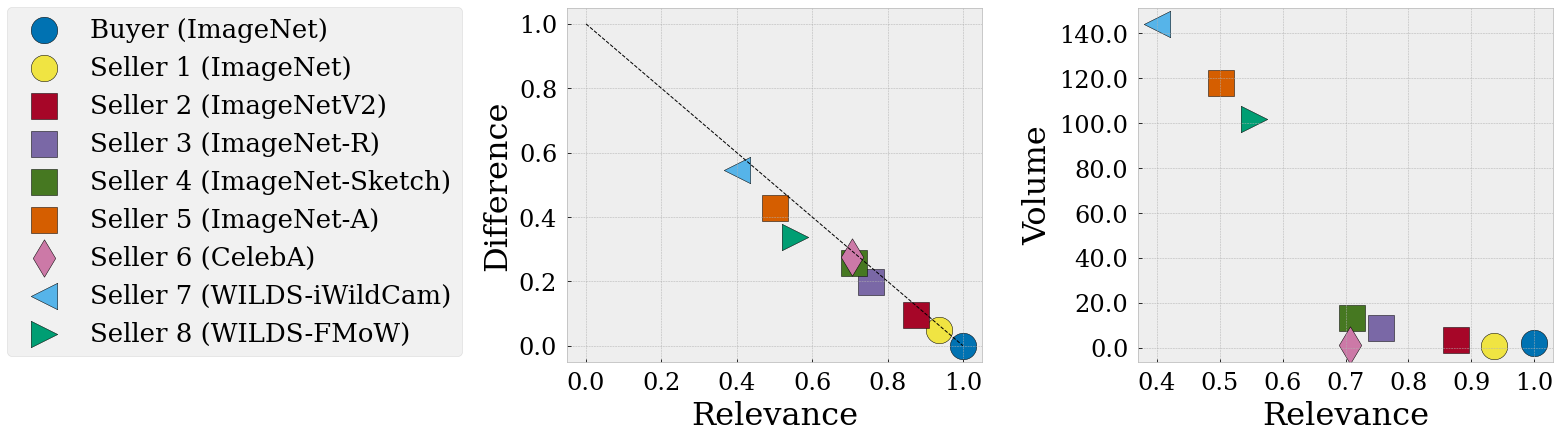

In [957]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 4)]

fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

ax[0].scatter(buyer2_self_eff1_rel, buyer2_self_eff1_div,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[0].scatter(buyer2_val2_eff1_rel, buyer2_val2_eff1_div,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
# ax[0].scatter(buyer2_val1_eff1_rel, buyer2_val1_eff1_div,   c=viridis[0], edgecolor='k', s=s, label=r'Seller (ImageNet 1k)')
# ax[0].scatter(buyer2_val2_eff1_rel, buyer2_val2_eff1_div,   c=viridis[1], edgecolor='k', s=s, label=r'Seller (ImageNet 10k)')
# ax[0].scatter(buyer2_val3_eff1_rel, buyer2_val3_eff1_div,   c=viridis[2], edgecolor='k', s=s, label=r'Seller (ImageNet 20k)')
# ax[0].scatter(buyer2_val4_eff1_rel, buyer2_val4_eff1_div,   c=viridis[3], edgecolor='k', s=s, label=r'Seller (ImageNet 30k)')
ax[0].scatter(buyer2_v2_eff1_rel, buyer2_v2_eff1_div,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[0].scatter(buyer2_r_eff1_rel, buyer2_r_eff1_div,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[0].scatter(buyer2_s_eff1_rel, buyer2_s_eff1_div,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[0].scatter(buyer2_a_eff1_rel, buyer2_a_eff1_div,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[0].scatter(buyer2_celeb_eff1_rel, buyer2_celeb_eff1_div,   c='C5', marker='d', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[0].scatter(buyer2_wild_eff1_rel, buyer2_wild_eff1_div,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[0].scatter(buyer2_fmow_eff1_rel, buyer2_fmow_eff1_div,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')

# ax[0].set_xlim(0.0, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(buyer2_self_eff1_rel, buyer2_self_eff1_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[1].scatter(buyer2_val2_eff1_rel, buyer2_val2_eff1_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
# ax[1].scatter(buyer2_val1_eff1_rel, buyer2_val1_eff1_vol,   c=viridis[0], edgecolor='k', s=s, label=r'Seller (ImageNet 1k)')
# ax[1].scatter(buyer2_val2_eff1_rel, buyer2_val2_eff1_vol,   c=viridis[1], edgecolor='k', s=s, label=r'Seller (ImageNet 10k)')
# ax[1].scatter(buyer2_val3_eff1_rel, buyer2_val3_eff1_vol,   c=viridis[2], edgecolor='k', s=s, label=r'Seller (ImageNet 20k)')
# ax[1].scatter(buyer2_val4_eff1_rel, buyer2_val4_eff1_vol,   c=viridis[3], edgecolor='k', s=s, label=r'Seller (ImageNet 30k)')
ax[1].scatter(buyer2_v2_eff1_rel, buyer2_v2_eff1_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[1].scatter(buyer2_r_eff1_rel, buyer2_r_eff1_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[1].scatter(buyer2_s_eff1_rel, buyer2_s_eff1_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[1].scatter(buyer2_a_eff1_rel, buyer2_a_eff1_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[1].scatter(buyer2_celeb_eff1_rel, buyer2_celeb_eff1_vol,   c='C5', marker='d', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[1].scatter(buyer2_wild_eff1_rel, buyer2_wild_eff1_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[1].scatter(buyer2_fmow_eff1_rel, buyer2_fmow_eff1_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
# ax[1].set_xlim(0.5, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
# ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(-1.60, 1.04))
plt.savefig(figures / f'imagenet-compare.pdf', bbox_inches='tight')
plt.show()

**Embedding**

/tmp/ipykernel_1868/2326973650.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2326973650.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.0f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2326973650.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2326973650.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{y:.1f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)


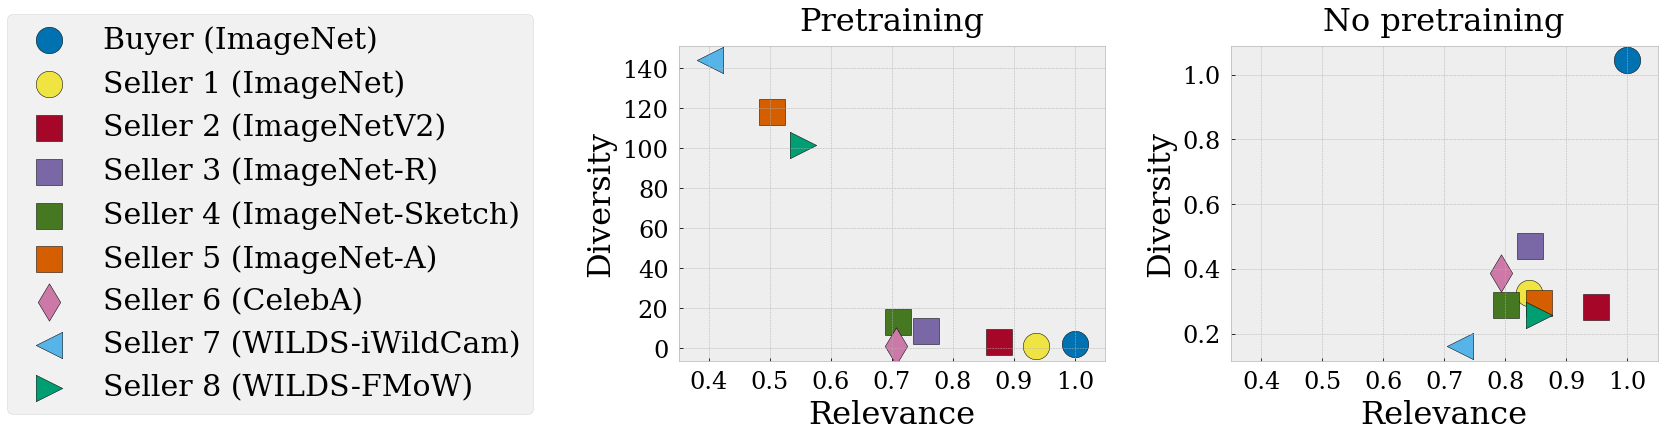

In [958]:
fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)
ax[0].scatter(buyer2_self_eff1_rel, buyer2_self_eff1_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[0].scatter(buyer2_v2_eff1_rel, buyer2_v2_eff1_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[0].scatter(buyer2_val2_eff1_rel, buyer2_val2_eff1_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[0].scatter(buyer2_r_eff1_rel, buyer2_r_eff1_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[0].scatter(buyer2_s_eff1_rel, buyer2_s_eff1_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[0].scatter(buyer2_a_eff1_rel, buyer2_a_eff1_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[0].scatter(buyer2_celeb_eff1_rel, buyer2_celeb_eff1_vol,   c='C5', marker='d', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[0].scatter(buyer2_wild_eff1_rel, buyer2_wild_eff1_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[0].scatter(buyer2_fmow_eff1_rel, buyer2_fmow_eff1_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].scatter(buyer2_self_eff1_no_pre_rel, buyer2_self_eff1_no_pre_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[1].scatter(buyer2_val2_eff1_no_pre_rel, buyer2_val2_eff1_no_pre_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[1].scatter(buyer2_v2_eff1_no_pre_rel, buyer2_v2_eff1_no_pre_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[1].scatter(buyer2_r_eff1_no_pre_rel, buyer2_r_eff1_no_pre_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[1].scatter(buyer2_s_eff1_no_pre_rel, buyer2_s_eff1_no_pre_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[1].scatter(buyer2_a_eff1_no_pre_rel, buyer2_a_eff1_no_pre_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[1].scatter(buyer2_celeb_eff1_no_pre_rel, buyer2_celeb_eff1_no_pre_vol,   c='C5', marker='d', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[1].scatter(buyer2_wild_eff1_no_pre_rel, buyer2_wild_eff1_no_pre_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[1].scatter(buyer2_fmow_eff1_no_pre_rel, buyer2_fmow_eff1_no_pre_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[0].set_xlim(0.35, 1.05)
ax[1].set_xlim(0.35, 1.05)
# y_max = ax[1].get_yticks().max()
# ax[0].set_ylim(-5, y_max)
# ax[1].set_ylim(-5, y_max)

ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.0f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
ax[0].set_title('Pretraining', fontsize=fontsize, pad=15)

ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([f'{y:.1f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
ax[1].set_title('No pretraining', fontsize=fontsize, pad=15)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-2}, bbox_to_anchor=(-1.60, 1.15))
plt.savefig(figures / f'imagenet-eff-pretrain.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_1868/4230550959.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/4230550959.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.0f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/4230550959.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/4230550959.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{y:.0f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/4230550959.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels([f'{x:.1f}' for x in ax[2].get_xticks()], fontsize=fontsize-8)


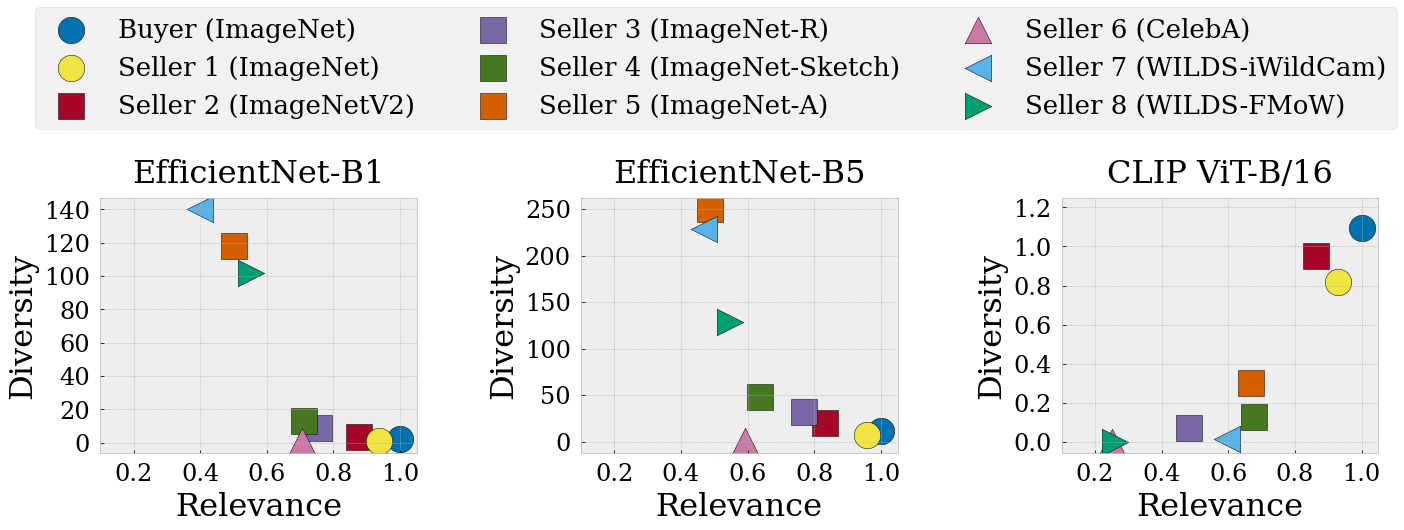

In [1069]:
fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(21, 7), ncols=3)
ax[0].scatter(buyer2_self_eff1_rel, buyer2_self_eff1_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[0].scatter(buyer2_v2_eff1_rel, buyer2_v2_eff1_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[0].scatter(buyer2_val2_eff1_rel, buyer2_val2_eff1_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[0].scatter(buyer2_r_eff1_rel, buyer2_r_eff1_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[0].scatter(buyer2_s_eff1_rel, buyer2_s_eff1_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[0].scatter(buyer2_a_eff1_rel, buyer2_a_eff1_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[0].scatter(buyer2_celeb_eff1_rel, buyer2_celeb_eff1_vol,   c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[0].scatter(buyer2_wild_eff1_rel, buyer2_wild_eff1_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[0].scatter(buyer2_fmow_eff1_rel, buyer2_fmow_eff1_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].scatter(buyer2_self_eff5_rel, buyer2_self_eff5_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[1].scatter(buyer2_v2_eff5_rel, buyer2_v2_eff5_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[1].scatter(buyer2_val2_eff5_rel, buyer2_val2_eff5_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[1].scatter(buyer2_r_eff5_rel, buyer2_r_eff5_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[1].scatter(buyer2_s_eff5_rel, buyer2_s_eff5_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[1].scatter(buyer2_a_eff5_rel, buyer2_a_eff5_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[1].scatter(buyer2_celeb_eff5_rel, buyer2_celeb_eff5_vol,   c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[1].scatter(buyer2_wild_eff5_rel, buyer2_wild_eff5_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[1].scatter(buyer2_fmow_eff5_rel, buyer2_fmow_eff5_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[2].scatter(buyer2_self_clip_rel, buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[2].scatter(buyer2_val2_clip_rel, buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[2].scatter(buyer2_v2_clip_rel, buyer2_v2_clip_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[2].scatter(buyer2_r_clip_rel, buyer2_r_clip_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[2].scatter(buyer2_s_clip_rel, buyer2_s_clip_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[2].scatter(buyer2_a_clip_rel, buyer2_a_clip_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[2].scatter(buyer2_celeb_clip_rel, buyer2_celeb_clip_vol,   c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[2].scatter(buyer2_wild_clip_rel, buyer2_wild_clip_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[2].scatter(buyer2_fmow_clip_rel, buyer2_fmow_clip_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[2].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[2].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[0].set_xlim(0.10, 1.05)
ax[1].set_xlim(0.10, 1.05)
ax[2].set_xlim(0.10, 1.05)
# y_max = ax[1].get_yticks().max()
# ax[0].set_ylim(-5, y_max)
ax[2].set_ylim(ax[2].get_ylim()[0], ax[2].get_ylim()[1] + 0.10)

ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.0f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
ax[0].set_title('EfficientNet-B1', fontsize=fontsize, pad=15)

ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([f'{y:.0f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
ax[1].set_title('EfficientNet-B5', fontsize=fontsize, pad=15)

ax[2].set_xticklabels([f'{x:.1f}' for x in ax[2].get_xticks()], fontsize=fontsize-8)
ax[2].set_yticklabels([f'{y:.1f}' for y in ax[2].get_yticks()], fontsize=fontsize-8)
ax[2].tick_params(axis='both', which='major', pad=10)
ax[2].set_title('CLIP ViT-B/16', fontsize=fontsize, pad=15)

plt.tight_layout(pad=7)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.10, 1.8), ncol=3)
plt.savefig(figures / f'imagenet-clip.pdf', bbox_inches='tight')
plt.show()

**number of components**

In [1078]:
comp1_buyer2_clip_pca, comp1_buyer2_clip_cov, comp1_buyer2_clip_values, comp1_buyer2_clip_components = utils.fit_buyer(buyer2_clip, n_components=1)
comp1_buyer2_self_clip_rel, comp1_buyer2_self_clip_div, comp1_buyer2_self_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(buyer2_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_val1_clip_rel, buyer2_val1_clip_div, buyer2_val1_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(val1_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_val2_clip_rel, comp1_buyer2_val2_clip_div, comp1_buyer2_val2_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(val2_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_val3_clip_rel, comp1_buyer2_val3_clip_div, comp1_buyer2_val3_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(val3_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_val4_clip_rel, comp1_buyer2_val4_clip_div, comp1_buyer2_val4_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(val4_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_v2_clip_rel, comp1_buyer2_v2_clip_div, comp1_buyer2_v2_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(v2_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_a_clip_rel, comp1_buyer2_a_clip_div, comp1_buyer2_a_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(a_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_r_clip_rel, comp1_buyer2_r_clip_div, comp1_buyer2_r_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(r_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_s_clip_rel, comp1_buyer2_s_clip_div, comp1_buyer2_s_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(s_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_celeb_clip_rel, comp1_buyer2_celeb_clip_div, comp1_buyer2_celeb_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(celeb_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_wild_clip_rel, comp1_buyer2_wild_clip_div, comp1_buyer2_wild_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(wild_clip, comp1_buyer2_clip_pca), omega=omega)
comp1_buyer2_fmow_clip_rel, comp1_buyer2_fmow_clip_div, comp1_buyer2_fmow_clip_vol = utils.get_valuation(comp1_buyer2_clip_values, comp1_buyer2_clip_components, *utils.project_seller(fmow_clip, comp1_buyer2_clip_pca), omega=omega)

comp2_buyer2_clip_pca, comp2_buyer2_clip_cov, comp2_buyer2_clip_values, comp2_buyer2_clip_components = utils.fit_buyer(buyer2_clip, n_components=5)
comp2_buyer2_self_clip_rel, comp2_buyer2_self_clip_div, comp2_buyer2_self_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(buyer2_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_val1_clip_rel, buyer2_val1_clip_div, buyer2_val1_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(val1_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_val2_clip_rel, comp2_buyer2_val2_clip_div, comp2_buyer2_val2_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(val2_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_val3_clip_rel, comp2_buyer2_val3_clip_div, comp2_buyer2_val3_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(val3_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_val4_clip_rel, comp2_buyer2_val4_clip_div, comp2_buyer2_val4_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(val4_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_v2_clip_rel, comp2_buyer2_v2_clip_div, comp2_buyer2_v2_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(v2_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_a_clip_rel, comp2_buyer2_a_clip_div, comp2_buyer2_a_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(a_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_r_clip_rel, comp2_buyer2_r_clip_div, comp2_buyer2_r_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(r_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_s_clip_rel, comp2_buyer2_s_clip_div, comp2_buyer2_s_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(s_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_celeb_clip_rel, comp2_buyer2_celeb_clip_div, comp2_buyer2_celeb_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(celeb_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_wild_clip_rel, comp2_buyer2_wild_clip_div, comp2_buyer2_wild_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(wild_clip, comp2_buyer2_clip_pca), omega=omega)
comp2_buyer2_fmow_clip_rel, comp2_buyer2_fmow_clip_div, comp2_buyer2_fmow_clip_vol = utils.get_valuation(comp2_buyer2_clip_values, comp2_buyer2_clip_components, *utils.project_seller(fmow_clip, comp2_buyer2_clip_pca), omega=omega)

comp3_buyer2_clip_pca, comp3_buyer2_clip_cov, comp3_buyer2_clip_values, comp3_buyer2_clip_components = utils.fit_buyer(buyer2_clip, n_components=10)
comp3_buyer2_self_clip_rel, comp3_buyer2_self_clip_div, comp3_buyer2_self_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(buyer2_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_val1_clip_rel, buyer2_val1_clip_div, buyer2_val1_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(val1_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_val2_clip_rel, comp3_buyer2_val2_clip_div, comp3_buyer2_val2_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(val2_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_val3_clip_rel, comp3_buyer2_val3_clip_div, comp3_buyer2_val3_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(val3_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_val4_clip_rel, comp3_buyer2_val4_clip_div, comp3_buyer2_val4_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(val4_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_v2_clip_rel, comp3_buyer2_v2_clip_div, comp3_buyer2_v2_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(v2_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_a_clip_rel, comp3_buyer2_a_clip_div, comp3_buyer2_a_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(a_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_r_clip_rel, comp3_buyer2_r_clip_div, comp3_buyer2_r_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(r_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_s_clip_rel, comp3_buyer2_s_clip_div, comp3_buyer2_s_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(s_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_celeb_clip_rel, comp3_buyer2_celeb_clip_div, comp3_buyer2_celeb_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(celeb_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_wild_clip_rel, comp3_buyer2_wild_clip_div, comp3_buyer2_wild_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(wild_clip, comp3_buyer2_clip_pca), omega=omega)
comp3_buyer2_fmow_clip_rel, comp3_buyer2_fmow_clip_div, comp3_buyer2_fmow_clip_vol = utils.get_valuation(comp3_buyer2_clip_values, comp3_buyer2_clip_components, *utils.project_seller(fmow_clip, comp3_buyer2_clip_pca), omega=omega)



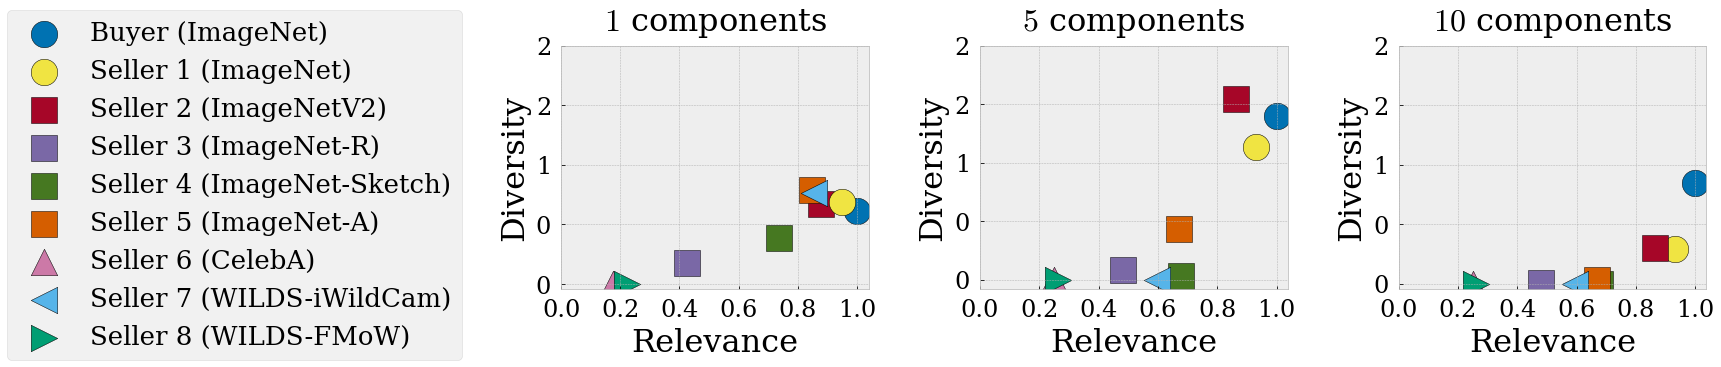

In [1085]:
fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(18, 6), ncols=3)
ax[0].scatter(comp1_buyer2_self_clip_rel, comp1_buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[0].scatter(comp1_buyer2_v2_clip_rel, comp1_buyer2_v2_clip_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[0].scatter(comp1_buyer2_val2_clip_rel, comp1_buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[0].scatter(comp1_buyer2_r_clip_rel, comp1_buyer2_r_clip_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[0].scatter(comp1_buyer2_s_clip_rel, comp1_buyer2_s_clip_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[0].scatter(comp1_buyer2_a_clip_rel, comp1_buyer2_a_clip_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[0].scatter(comp1_buyer2_celeb_clip_rel, comp1_buyer2_celeb_clip_vol,   c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[0].scatter(comp1_buyer2_wild_clip_rel, comp1_buyer2_wild_clip_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[0].scatter(comp1_buyer2_fmow_clip_rel, comp1_buyer2_fmow_clip_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].scatter(comp2_buyer2_self_clip_rel, comp2_buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[1].scatter(comp2_buyer2_val2_clip_rel, comp2_buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[1].scatter(comp2_buyer2_v2_clip_rel, comp2_buyer2_v2_clip_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[1].scatter(comp2_buyer2_r_clip_rel, comp2_buyer2_r_clip_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[1].scatter(comp2_buyer2_s_clip_rel, comp2_buyer2_s_clip_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[1].scatter(comp2_buyer2_a_clip_rel, comp2_buyer2_a_clip_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[1].scatter(comp2_buyer2_celeb_clip_rel, comp2_buyer2_celeb_clip_vol,   c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[1].scatter(comp2_buyer2_wild_clip_rel, comp2_buyer2_wild_clip_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[1].scatter(comp2_buyer2_fmow_clip_rel, comp2_buyer2_fmow_clip_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[2].scatter(comp3_buyer2_self_clip_rel, comp3_buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[2].scatter(comp3_buyer2_val2_clip_rel, comp3_buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[2].scatter(comp3_buyer2_v2_clip_rel, comp3_buyer2_v2_clip_vol,   c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[2].scatter(comp3_buyer2_r_clip_rel, comp3_buyer2_r_clip_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[2].scatter(comp3_buyer2_s_clip_rel, comp3_buyer2_s_clip_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[2].scatter(comp3_buyer2_a_clip_rel, comp3_buyer2_a_clip_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[2].scatter(comp3_buyer2_celeb_clip_rel, comp3_buyer2_celeb_clip_vol,   c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[2].scatter(comp3_buyer2_wild_clip_rel, comp3_buyer2_wild_clip_vol,   c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[2].scatter(comp3_buyer2_fmow_clip_rel, comp3_buyer2_fmow_clip_vol,   c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[2].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[2].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=fontsize-8)
ax[0].set_yticks([0, 0.5, 1, 1.5, 2], fontsize=fontsize-8)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.0f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
ax[0].set_title(r'$1$ components', fontsize=fontsize, pad=15)

ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=fontsize-8)
ax[1].set_yticks([0, 0.5, 1, 1.5, 2], fontsize=fontsize-8)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([f'{y:.0f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
ax[1].set_title(r'$5$ components', fontsize=fontsize, pad=15)

ax[2].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=fontsize-8)
ax[2].set_yticks([0, 0.5, 1, 1.5, 2], fontsize=fontsize-8)
ax[2].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[2].set_yticklabels([f'{y:.0f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[2].tick_params(axis='both', which='major', pad=10)
ax[2].set_title(r'$10$ components', fontsize=fontsize, pad=15)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(-3.00, 1.20))
plt.savefig(figures / f'imagenet-components.pdf', bbox_inches='tight')
plt.show()

**number of buyer samples**

/tmp/ipykernel_1868/3847018807.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/3847018807.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/3847018807.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/3847018807.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{y:.1f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/3847018807.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)


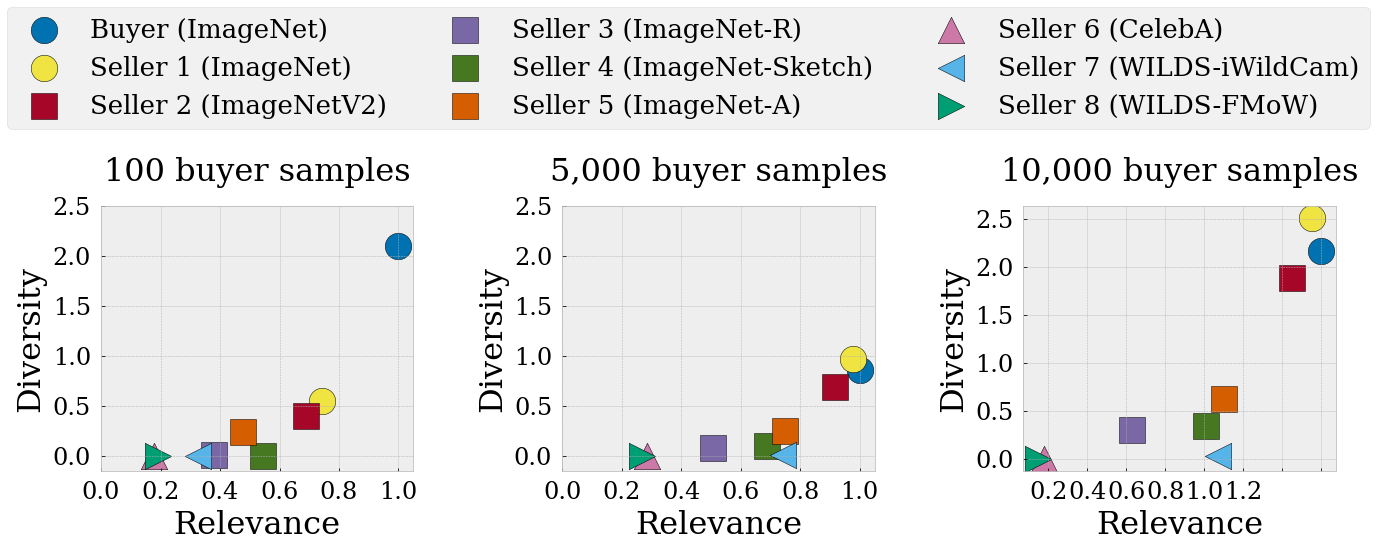

In [1110]:
fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(20, 7), ncols=3)
ax[0].scatter(buyer1_self_clip_rel, buyer1_self_clip_vol, c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[0].scatter(buyer1_val2_clip_rel, buyer1_val2_clip_vol, c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[0].scatter(buyer1_v2_clip_rel, buyer1_v2_clip_vol, c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[0].scatter(buyer1_r_clip_rel, buyer1_r_clip_vol, c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[0].scatter(buyer1_s_clip_rel, buyer1_s_clip_vol, c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[0].scatter(buyer1_a_clip_rel, buyer1_a_clip_vol, c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[0].scatter(buyer1_celeb_clip_rel, buyer1_celeb_clip_vol, c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[0].scatter(buyer1_wild_clip_rel, buyer1_wild_clip_vol, c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[0].scatter(buyer1_fmow_clip_rel, buyer1_fmow_clip_vol, c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].scatter(buyer3_self_clip_rel, buyer3_self_clip_vol, c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[1].scatter(buyer3_val2_clip_rel, buyer3_val2_clip_vol, c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[1].scatter(buyer3_v2_clip_rel, buyer3_v2_clip_vol, c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[1].scatter(buyer3_r_clip_rel, buyer3_r_clip_vol, c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[1].scatter(buyer3_s_clip_rel, buyer3_s_clip_vol, c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[1].scatter(buyer3_a_clip_rel, buyer3_a_clip_vol, c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[1].scatter(buyer3_celeb_clip_rel, buyer3_celeb_clip_vol, c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[1].scatter(buyer3_wild_clip_rel, buyer3_wild_clip_vol, c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[1].scatter(buyer3_fmow_clip_rel, buyer3_fmow_clip_vol, c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[2].scatter(buyer4_self_clip_rel, buyer4_self_clip_vol, c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[2].scatter(buyer4_val2_clip_rel, buyer4_val2_clip_vol, c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 (ImageNet)')
ax[2].scatter(buyer4_v2_clip_rel, buyer4_v2_clip_vol, c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (ImageNetV2)')
ax[2].scatter(buyer4_r_clip_rel, buyer4_r_clip_vol, c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
ax[2].scatter(buyer4_s_clip_rel, buyer4_s_clip_vol, c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
ax[2].scatter(buyer4_a_clip_rel, buyer4_a_clip_vol, c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[2].scatter(buyer4_celeb_clip_rel, buyer4_celeb_clip_vol, c='C5', marker='^', edgecolor='k', s=s, label=r'Seller 6 (CelebA)')
ax[2].scatter(buyer4_wild_clip_rel, buyer4_wild_clip_vol, c='C6', marker='<', edgecolor='k', s=s, label=r'Seller 7 (WILDS-iWildCam)')
ax[2].scatter(buyer4_fmow_clip_rel, buyer4_fmow_clip_vol, c='C7', marker='>', edgecolor='k', s=s, label=r'Seller 8 (WILDS-FMoW)')
ax[2].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[2].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[0].set_xlim(0.00, 1.05)
ax[1].set_xlim(0.00, 1.05)
y_max = max(ax[0].get_yticks().max(), ax[1].get_yticks().max(), ax[2].get_yticks().max())
ax[0].set_ylim(-0.15, y_max)
ax[1].set_ylim(-0.15, y_max)

ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
# ax[0].set_yticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
ax[0].set_title('100 buyer samples', fontsize=fontsize, pad=25)

ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([f'{y:.1f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
# ax[1].set_yticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
ax[1].set_title('5,000 buyer samples', fontsize=fontsize, pad=25)

ax[2].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[2].set_yticklabels([f'{y:.1f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
# ax[1].set_yticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=fontsize-8)
ax[2].tick_params(axis='both', which='major', pad=10)
ax[2].set_title('10,000 buyer samples', fontsize=fontsize, pad=25)


plt.tight_layout(pad=6)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.15, 1.8), ncol=3)
plt.savefig(figures / f'imagenet-num-buyer-samples.pdf', bbox_inches='tight')
plt.show()

**number of seller samples**

/tmp/ipykernel_1868/1316001331.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/1316001331.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{y:.1f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)


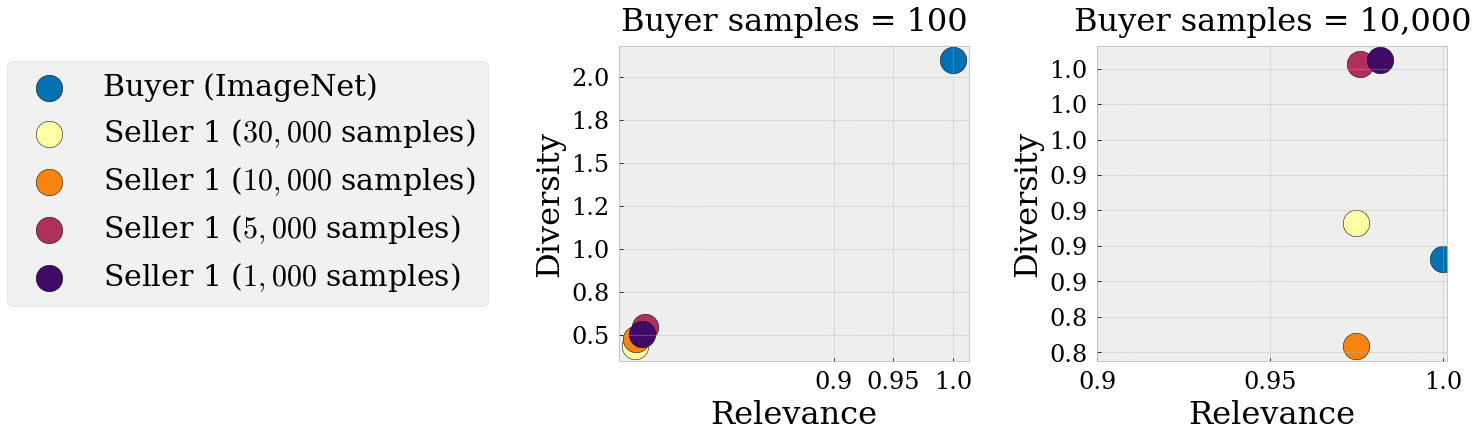

In [1091]:
inferno = [np.array([matplotlib.colormaps['inferno'].colors[int(k)]]) for k in np.linspace(50, 255, 4)]

fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(14, 7), ncols=2)
ax[0].scatter(buyer1_self_clip_rel, buyer1_self_clip_vol, c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[0].scatter(buyer1_val4_clip_rel, buyer1_val4_clip_vol, c=inferno[3], edgecolor='k', s=s, label=r'Seller 1 ($30,000$ ImageNet samples)')
ax[0].scatter(buyer1_val3_clip_rel, buyer1_val3_clip_vol, c=inferno[2], edgecolor='k', s=s, label=r'Seller 1 ($10,000$ ImageNet samples)')
ax[0].scatter(buyer1_val2_clip_rel, buyer1_val2_clip_vol, c=inferno[1], edgecolor='k', s=s, label=r'Seller 1 ($5,000$ ImageNet samples)')
ax[0].scatter(buyer1_val1_clip_rel, buyer1_val1_clip_vol, c=inferno[0], edgecolor='k', s=s, label=r'Seller 1 ($1,000$ ImageNet samples)')
# ax[0].scatter(buyer1_v2_clip_rel, buyer1_v2_clip_vol, c='C1', edgecolor='k', marker='s', s=s, label=r'Seller 2 (ImageNetV2)')
# ax[0].scatter(buyer1_r_clip_rel, buyer1_r_clip_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
# ax[0].scatter(buyer1_s_clip_rel, buyer1_s_clip_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
# ax[0].scatter(buyer1_a_clip_rel, buyer1_a_clip_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].scatter(buyer4_self_clip_rel, buyer4_self_clip_vol, c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[1].scatter(buyer4_val4_clip_rel, buyer4_val4_clip_vol, c=inferno[3], edgecolor='k', s=s, label=r'Seller 1 ($30,000$ samples)')
ax[1].scatter(buyer4_val3_clip_rel, buyer4_val3_clip_vol, c=inferno[2], edgecolor='k', s=s, label=r'Seller 1 ($10,000$ samples)')
ax[1].scatter(buyer4_val2_clip_rel, buyer4_val2_clip_vol, c=inferno[1], edgecolor='k', s=s, label=r'Seller 1 ($5,000$ samples)')
ax[1].scatter(buyer4_val1_clip_rel, buyer4_val1_clip_vol, c=inferno[0], edgecolor='k', s=s, label=r'Seller 1 ($1,000$ samples)')
# ax[1].scatter(buyer4_v2_clip_rel, buyer4_v2_clip_vol, c='C1', edgecolor='k', marker='s', s=s, label=r'Seller 2 (ImageNetV2)')
# ax[1].scatter(buyer4_r_clip_rel, buyer4_r_clip_vol,   c='C2', marker='s', edgecolor='k', s=s, label=r'Seller 3 (ImageNet-R)')
# ax[1].scatter(buyer4_s_clip_rel, buyer4_s_clip_vol,   c='C3', marker='s', edgecolor='k', s=s, label=r'Seller 4 (ImageNet-Sketch)')
# ax[1].scatter(buyer4_a_clip_rel, buyer4_a_clip_vol,   c='C4', marker='s', edgecolor='k', s=s, label=r'Seller 5 (ImageNet-A)')
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

# x_min = min(ax[0].get_xticks().min(), ax[1].get_xticks().min())
# ax[0].set_xlim(x_min, 1.05)
# ax[1].set_xlim(x_min, 1.05)
# y_max = max(ax[0].get_yticks().max(), ax[1].get_yticks().max()) + 0.1
# ax[0].set_ylim(0.0, y_max)
# ax[1].set_ylim(0.0, y_max)

ax[0].set_xticks([0.90, 0.95, 1], [0.90, 0.95, 1.00], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
ax[0].set_title('Buyer samples = 100', fontsize=fontsize, pad=15)

ax[1].set_xticks([0.90, 0.95, 1], [0.90, 0.95, 1.00], fontsize=fontsize-8)
ax[1].set_yticklabels([f'{y:.1f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
ax[1].set_title('Buyer samples = 10,000', fontsize=fontsize, pad=15)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-2}, bbox_to_anchor=(-1.70, 1.00))
plt.savefig(figures / f'imagenet-num-seller-samples.pdf', bbox_inches='tight')
plt.show()

**Duplication robustness**

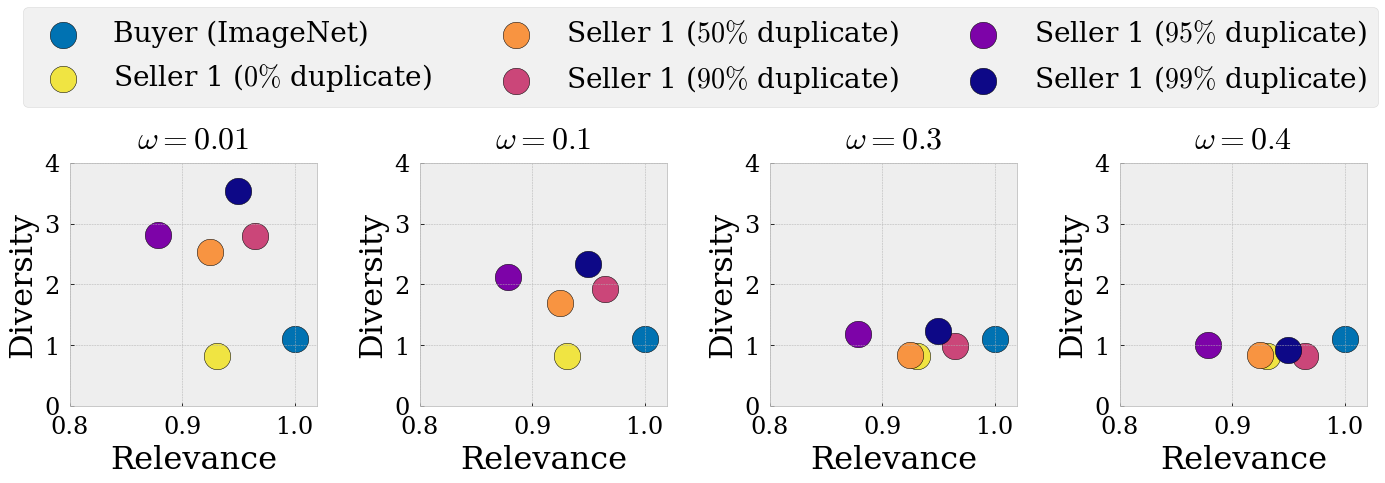

In [1112]:
import matplotlib
plasma = [np.array([matplotlib.colormaps['plasma'].colors[int(k)]]) for k in np.linspace(255, 0, 5)]

fontsize = 32
s = 700

omega1 = 0.1

omega1_dup1_clip_rel, omega1_dup1_clip_div, omega1_dup1_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 2)].repeat(2, 1), buyer2_clip_pca), omega=omega1)
omega1_dup2_clip_rel, omega1_dup2_clip_div, omega1_dup2_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 5)].repeat(5, 1), buyer2_clip_pca), omega=omega1)
omega1_dup3_clip_rel, omega1_dup3_clip_div, omega1_dup3_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 10)].repeat(10, 1), buyer2_clip_pca), omega=omega1)
omega1_dup4_clip_rel, omega1_dup4_clip_div, omega1_dup4_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 50)].repeat(50, 1), buyer2_clip_pca), omega=omega1)
omega1_dup5_clip_rel, omega1_dup5_clip_div, omega1_dup5_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 100)].repeat(100, 1), buyer2_clip_pca), omega=omega1)

omega2 = 0.2

omega2_dup1_clip_rel, omega2_dup1_clip_div, omega2_dup1_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 2)].repeat(2, 1), buyer2_clip_pca), omega=omega2)
omega2_dup2_clip_rel, omega2_dup2_clip_div, omega2_dup2_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 5)].repeat(5, 1), buyer2_clip_pca), omega=omega2)
omega2_dup3_clip_rel, omega2_dup3_clip_div, omega2_dup3_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 10)].repeat(10, 1), buyer2_clip_pca), omega=omega2)
omega2_dup4_clip_rel, omega2_dup4_clip_div, omega2_dup4_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 50)].repeat(50, 1), buyer2_clip_pca), omega=omega2)
omega2_dup5_clip_rel, omega2_dup5_clip_div, omega2_dup5_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 100)].repeat(100, 1), buyer2_clip_pca), omega=omega2)

omega3 = 0.3

omega3_dup1_clip_rel, omega3_dup1_clip_div, omega3_dup1_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 2)].repeat(2, 1), buyer2_clip_pca), omega=omega3)
omega3_dup2_clip_rel, omega3_dup2_clip_div, omega3_dup2_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 5)].repeat(5, 1), buyer2_clip_pca), omega=omega3)
omega3_dup3_clip_rel, omega3_dup3_clip_div, omega3_dup3_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 10)].repeat(10, 1), buyer2_clip_pca), omega=omega3)
omega3_dup4_clip_rel, omega3_dup4_clip_div, omega3_dup4_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 50)].repeat(50, 1), buyer2_clip_pca), omega=omega3)
omega3_dup5_clip_rel, omega3_dup5_clip_div, omega3_dup5_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 100)].repeat(100, 1), buyer2_clip_pca), omega=omega3)

omega4 = 0.4

omega4_dup1_clip_rel, omega4_dup1_clip_div, omega4_dup1_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 2)].repeat(2, 1), buyer2_clip_pca), omega=omega4)
omega4_dup2_clip_rel, omega4_dup2_clip_div, omega4_dup2_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 5)].repeat(5, 1), buyer2_clip_pca), omega=omega4)
omega4_dup3_clip_rel, omega4_dup3_clip_div, omega4_dup3_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 10)].repeat(10, 1), buyer2_clip_pca), omega=omega4)
omega4_dup4_clip_rel, omega4_dup4_clip_div, omega4_dup4_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 50)].repeat(50, 1), buyer2_clip_pca), omega=omega4)
omega4_dup5_clip_rel, omega4_dup5_clip_div, omega4_dup5_clip_vol = utils.get_valuation(buyer2_clip_values, buyer2_clip_components, *utils.project_seller(val2_clip[:int(val2_clip.shape[0] // 100)].repeat(100, 1), buyer2_clip_pca), omega=omega4)

fig, ax = plt.subplots(figsize=(20, 6), ncols=4)
ax[0].scatter(buyer2_self_clip_rel, buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[0].scatter(buyer2_val2_clip_rel, buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 ($100\%$ unique)')
ax[0].scatter(omega1_dup1_clip_rel, omega1_dup1_clip_vol,   c=plasma[1], edgecolor='k', s=s, label=r'Seller 1 ($50\%$ unique)')
# ax[0].scatter(omega1_dup2_clip_rel, omega1_dup2_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($20\%$ unique)')
ax[0].scatter(omega1_dup3_clip_rel, omega1_dup3_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($10\%$ unique)')
ax[0].scatter(omega1_dup4_clip_rel, omega1_dup4_clip_vol,   c=plasma[3], edgecolor='k', s=s, label=r'Seller 1 ($5\%$ unique)')
ax[0].scatter(omega1_dup5_clip_rel, omega1_dup5_clip_vol,   c=plasma[4], edgecolor='k', s=s, label=r'Seller 1 ($1\%$ unique)')
ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].scatter(buyer2_self_clip_rel, buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[1].scatter(buyer2_val2_clip_rel, buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 ($100\%$ unique)')
ax[1].scatter(omega2_dup1_clip_rel, omega2_dup1_clip_vol,   c=plasma[1], edgecolor='k', s=s, label=r'Seller 1 ($50\%$ unique)')
# ax[1].scatter(omega2_dup2_clip_rel, omega2_dup2_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($20\%$ unique)')
ax[1].scatter(omega2_dup3_clip_rel, omega2_dup3_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($10\%$ unique)')
ax[1].scatter(omega2_dup4_clip_rel, omega2_dup4_clip_vol,   c=plasma[3], edgecolor='k', s=s, label=r'Seller 1 ($5\%$ unique)')
ax[1].scatter(omega2_dup5_clip_rel, omega2_dup5_clip_vol,   c=plasma[4], edgecolor='k', s=s, label=r'Seller 1 ($1\%$ unique)')
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[2].scatter(buyer2_self_clip_rel, buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[2].scatter(buyer2_val2_clip_rel, buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 ($100\%$ unique)')
ax[2].scatter(omega3_dup1_clip_rel, omega3_dup1_clip_vol,   c=plasma[1], edgecolor='k', s=s, label=r'Seller 1 ($50\%$ unique)')
# ax[2].scatter(omega3_dup2_clip_rel, omega3_dup2_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($20\%$ unique)')
ax[2].scatter(omega3_dup3_clip_rel, omega3_dup3_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($10\%$ unique)')
ax[2].scatter(omega3_dup4_clip_rel, omega3_dup4_clip_vol,   c=plasma[3], edgecolor='k', s=s, label=r'Seller 1 ($5\%$ unique)')
ax[2].scatter(omega3_dup5_clip_rel, omega3_dup5_clip_vol,   c=plasma[4], edgecolor='k', s=s, label=r'Seller 1 ($1\%$ unique)')
ax[2].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[2].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[3].scatter(buyer2_self_clip_rel, buyer2_self_clip_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (ImageNet)')
ax[3].scatter(buyer2_val2_clip_rel, buyer2_val2_clip_vol,   c='#F0E442', edgecolor='k', s=s, label=r'Seller 1 ($0\%$ duplicate)')
ax[3].scatter(omega4_dup1_clip_rel, omega4_dup1_clip_vol,   c=plasma[1], edgecolor='k', s=s, label=r'Seller 1 ($50\%$ duplicate)')
# ax[3].scatter(omega4_dup2_clip_rel, omega4_dup2_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($20\%$ unique)')
ax[3].scatter(omega4_dup3_clip_rel, omega4_dup3_clip_vol,   c=plasma[2], edgecolor='k', s=s, label=r'Seller 1 ($90\%$ duplicate)')
ax[3].scatter(omega4_dup4_clip_rel, omega4_dup4_clip_vol,   c=plasma[3], edgecolor='k', s=s, label=r'Seller 1 ($95\%$ duplicate)')
ax[3].scatter(omega4_dup5_clip_rel, omega4_dup5_clip_vol,   c=plasma[4], edgecolor='k', s=s, label=r'Seller 1 ($99\%$ duplicate)')
ax[3].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[3].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[0].set_xticks([0.80, 0.9,  1], [0.80, 0.90, 1.00], fontsize=fontsize-8)
ax[0].set_yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
ax[0].set_title(r'$\omega=0.01$', fontsize=fontsize, pad=15)

ax[1].set_xticks([0.80, 0.9,  1], [0.80, 0.90, 1.00], fontsize=fontsize-8)
ax[1].set_yticks([1, 2, 3, 4], [1, 2, 3, 4], fontsize=fontsize-8)
ax[1].set_yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
ax[1].set_title(r'$\omega=0.1$', fontsize=fontsize, pad=15)

ax[2].set_xticks([0.80, 0.9,  1], [0.80, 0.90, 1.00], fontsize=fontsize-8)
ax[2].set_yticks([1, 2, 3, 4], [1, 2, 3, 4], fontsize=fontsize-8)
ax[2].set_yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], fontsize=fontsize-8)
ax[2].tick_params(axis='both', which='major', pad=10)
ax[2].set_title(r'$\omega=0.3$', fontsize=fontsize, pad=15)

ax[3].set_xticks([0.80, 0.9,  1], [0.80, 0.90, 1.00], fontsize=fontsize-8)
ax[3].set_yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], fontsize=fontsize-8)
ax[3].tick_params(axis='both', which='major', pad=10)
ax[3].set_title(r'$\omega=0.4$', fontsize=fontsize, pad=15)

ax[0].set_xlim(0.80, 1.02)
ax[1].set_xlim(0.80, 1.02)
ax[2].set_xlim(0.80, 1.02)
ax[3].set_xlim(0.80, 1.02)
# y_min = min(ax[0].get_yticks().min(), ax[1].get_yticks().min(), ax[2].get_yticks().min()) - 0.5
# y_min = 0 - 0.3
# y_max = max(ax[0].get_yticks().max(), ax[1].get_yticks().max(), ax[2].get_yticks().max(), ax[3].get_yticks().max()) + 0.1
# ax[0].set_ylim(y_min, y_max)
# ax[1].set_ylim(y_min, y_max)
# ax[2].set_ylim(y_min, y_max)
# ax[3].set_ylim(y_min, y_max)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(1.10, 1.70), ncol=3)
plt.savefig(figures / f'imagenet-duplication.pdf', bbox_inches='tight')
plt.show()

**multi-modal data with CLIP**

In [478]:
from itertools import chain

In [483]:
nih = list(chain(
    Path('../data/nih-chest-xray-dataset/images_001/images/').iterdir(),
    Path('../data/nih-chest-xray-dataset/images_002/images/').iterdir(),
    Path('../data/nih-chest-xray-dataset/images_003/images/').iterdir(),
    Path('../data/nih-chest-xray-dataset/images_004/images/').iterdir(),
))

In [375]:
candid = pd.read_csv('../data/CANDID-PTX/Pneumothorax_reports.csv')
candid_normal = candid.query('EncodedPixels == "-1"')
candid_abnormal = candid.query('EncodedPixels != "-1"')

In [699]:
candid_images = Path('../data/CANDID-PTX/new_dataset/dataset/')
normal_images = [candid_images / candid_normal.iloc[i].SOPInstanceUID for i in range(candid_normal.shape[0])]
abnormal_images = [candid_images / candid_abnormal.iloc[i].SOPInstanceUID for i in range(candid_abnormal.shape[0])]

In [ ]:
bad_files = []
for image in candid_images.iterdir():
    try:
        pydicom.dcmread(image)
    except:
        bad_files.append(image.stem)

In [ ]:
print(len(bad_files))

In [ ]:
valid_images = set([x.stem for x in candid_images.iterdir() if x.stem not in bad_files])

In [ ]:
normal_images = [x for x in normal_images if x.stem in valid_images]
abnormal_images = [x for x in abnormal_images if x.stem in valid_images]
print(len(normal_images), len(abnormal_images))

In [ ]:
reload(utils)
dicom_transforms = transforms.Compose([
    transforms.Lambda(lambda dcm: pydicom.dcmread(dcm, force=True).pixel_array),
    transforms.Lambda(lambda img: (255 * (np.maximum(0, img) / img.max())[:, :, None]).astype(np.float32)),
    transforms.ToPILImage(),
    clip_preprocess, 
])
normal_ds = utils.simple_DS(normal_images, transforms=dicom_transforms)
abnormal_ds = utils.simple_DS(abnormal_images, transforms=dicom_transforms)
nih_ds = utils.simple_DS(nih, transforms=transforms.Compose([transforms.Lambda(lambda x: Image.open(x)), clip_preprocess]))

batch_size = 32
image_normal_loader = torch.utils.data.DataLoader(normal_ds, batch_size=batch_size)
image_abnormal_loader = torch.utils.data.DataLoader(abnormal_ds, batch_size=batch_size)
nih_loader = torch.utils.data.DataLoader(nih_ds, batch_size=batch_size)

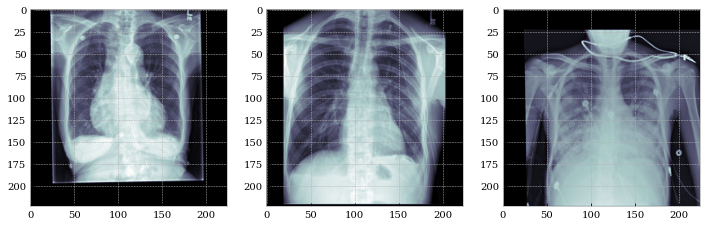

In [708]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(normal_ds[0][0], cmap=plt.cm.bone)
ax[1].imshow(abnormal_ds[0][0], cmap=plt.cm.bone)
ax[2].imshow(nih_ds[0][0], cmap=plt.cm.bone)

In [649]:
def get_clip_text_features(dataset, num_samples=1000, clip_model=clip_model, max_token_length=77):
    features = []
    for i in tqdm(range(num_samples), total=num_samples):
        text = dataset[i][0]
        random_start = np.random.choice(np.arange(max(1, len(text) - max_token_length)))
        text = clip.tokenize(text[random_start:random_start + max_token_length])
        features.append(clip_model.encode_text(text.cuda()).detach().cpu())
        
    torch.cuda.empty_cache()
    return torch.cat(features)

MAX_TOKEN_LENGTH = 77
text_transforms = transforms.Compose([
    transforms.Lambda(lambda x: ' '.join(x.split()[(start := np.random.choice(np.arange(max(1, len(x.split()) - MAX_TOKEN_LENGTH)))): start+MAX_TOKEN_LENGTH])),
    transforms.Lambda(lambda x: clip.tokenize(x, truncate=True)),
])

n = 10000
subset = lambda ds, n=n: Subset(ds, np.arange(min(len(ds), n) + 1))

In [650]:
report_normal_loader = DataLoader(subset(utils.simple_DS(candid_normal.Report.values, transforms=text_transforms)), batch_size=32)
report_abnormal_loader = DataLoader(subset(utils.simple_DS(candid_abnormal.Report.values, transforms=text_transforms)), batch_size=32)

In [651]:
imdb = pd.read_csv('../data/imdb/IMDB Dataset.csv')

tweet1 = pd.read_csv('../data/health-tweets/Health-Tweets/bbchealth.txt', sep='|', header=None, error_bad_lines=False) 
tweet2 = pd.read_csv('../data/health-tweets/Health-Tweets/cbchealth.txt', sep='|', header=None, error_bad_lines=False) 
tweet3 = pd.read_csv('../data/health-tweets/Health-Tweets/cnnhealth.txt', sep='|', header=None, error_bad_lines=False) 
tweet4 = pd.read_csv('../data/health-tweets/Health-Tweets/everydayhealth.txt', sep='|', header=None, error_bad_lines=False) 
tweet5 = pd.read_csv('../data/health-tweets/Health-Tweets/foxnewshealth.txt', sep='|', header=None, encoding='latin', error_bad_lines=False) 
tweet6 = pd.read_csv('../data/health-tweets/Health-Tweets/nprhealth.txt', sep='|', header=None, error_bad_lines=False) 
tweet7 = pd.read_csv('../data/health-tweets/Health-Tweets/nytimeshealth.txt', sep='|', header=None, error_bad_lines=False) 
tweet8 = pd.read_csv('../data/health-tweets/Health-Tweets/reuters_health.txt', sep='|', header=None, error_bad_lines=False) 
tweets = [tweet1, tweet2, tweet3, tweet4, tweet5, tweet6, tweet7, tweet8]
print(list(map(len, tweets)))
tweets = pd.concat(tweets)

imdb_loader = DataLoader(subset(utils.simple_DS(imdb.review.values, transforms=text_transforms)), batch_size=32)
tweets_loader = DataLoader(subset(utils.simple_DS(tweets.iloc[:, 2].values, transforms=text_transforms)), batch_size=32)

/tmp/ipykernel_1868/2085589505.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  tweet1 = pd.read_csv('../data/health-tweets/Health-Tweets/bbchealth.txt', sep='|', header=None, error_bad_lines=False)
/tmp/ipykernel_1868/2085589505.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  tweet2 = pd.read_csv('../data/health-tweets/Health-Tweets/cbchealth.txt', sep='|', header=None, error_bad_lines=False)
b'Skipping line 846: expected 3 fields, saw 4\nSkipping line 904: expected 3 fields, saw 4\nSkipping line 914: expected 3 fields, saw 4\nSkipping line 1264: expected 3 fields, saw 4\nSkipping line 1269: expected 3 fields, saw 4\nSkipping line 1293: expected 3 fields, saw 4\nSkipping line 1348: expected 3 fields, saw 4\nSkipping line 1430: expected 3 fields, saw 4\nSkipping line 1486: expected 3 fields, 

[3929, 3728, 4045, 3239, 2000, 4837, 5947, 4719]


In [926]:
root_dir = '../data/wilds/'

amazon = wilds.get_dataset(dataset='amazon', root_dir=root_dir)
civil = wilds.get_dataset(dataset='civilcomments', root_dir=root_dir)

In [927]:
wild_text_transforms = transforms.Compose([transforms.Lambda(lambda x: x[0]), text_transforms])

amazon_loader = DataLoader(subset(utils.simple_DS(amazon, transforms=wild_text_transforms)), batch_size=32)
civil_loader = DataLoader(subset(utils.simple_DS(civil, transforms=wild_text_transforms)), batch_size=32)

In [928]:
with torch.no_grad():
    amazon_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(amazon_loader))])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 17.79it/s]


In [653]:
with torch.no_grad():
    report_normal_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(report_normal_loader))])
    report_abnormal_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(report_abnormal_loader))])
    imdb_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(imdb_loader))])
    tweets_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(tweets_loader))])
    amazon_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(amazon_loader))])
    civil_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(civil_loader))])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:18<00:00, 17.38it/s]


In [705]:
with torch.no_grad():
    image_normal_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(image_normal_loader))])
    image_abnormal_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(image_abnormal_loader))])
    nih_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(nih_loader))])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 430/430 [11:35<00:00,  1.62s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [02:15<00:00,  1.41s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1094/1094 [30:51<00:00,  1.69s/it]


In [1009]:
n_components = 3
whiten       = True
omega = 0.1
threshold = 1e-1

buyer_image_normal = image_normal_features[:1000]
seller_image_normal = image_normal_features[1000:]

buyer_image_pca, buyer_image_cov, buyer_image_values, buyer_image_components = utils.fit_buyer(buyer_image_normal, n_components=n_components)

buyer_image_buyer_candid_normal_image_rel, buyer_image_buyer_candid_normal_image_div, buyer_image_buyer_candid_normal_image_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(buyer_image_normal, buyer_image_pca), omega=omega)
buyer_image_seller_candid_normal_image_rel, buyer_image_seller_candid_normal_image_div, buyer_image_seller_candid_normal_image_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(seller_image_normal, buyer_image_pca), omega=omega)
buyer_image_seller_candid_abnormal_image_rel, buyer_image_seller_candid_abnormal_image_div, buyer_image_seller_candid_abnormal_image_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(image_abnormal_features, buyer_image_pca), omega=omega)
buyer_image_seller_nih_rel, buyer_image_seller_nih__div, buyer_image_seller_nih_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(nih_features, buyer_image_pca), omega=omega)
buyer_image_seller_val_rel, buyer_image_seller_val_div, buyer_image_seller_val_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(val2_clip, buyer_image_pca), omega=omega)
buyer_image_seller_celeb_rel, buyer_image_seller_celeb_div, buyer_image_seller_celeb_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(celeb_clip, buyer_image_pca), omega=omega)
buyer_image_seller_wild_rel, buyer_image_seller_wild_div, buyer_image_seller_wild_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(wild_clip, buyer_image_pca), omega=omega)
buyer_image_seller_fmow_rel, buyer_image_seller_fmow_div, buyer_image_seller_fmow_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(fmow_clip, buyer_image_pca), omega=omega)

buyer_image_seller_candid_normal_report_rel, buyer_image_seller_candid_normal_report_div, buyer_image_seller_candid_normal_report_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(seller_report_normal, buyer_image_pca), omega=omega)
buyer_image_seller_candid_abnormal_report_rel, buyer_image_seller_candid_abnormal_report_div, buyer_image_seller_candid_abnormal_report_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(report_abnormal_features, buyer_image_pca), omega=omega)
buyer_image_seller_imdb_rel, buyer_image_seller_imdb_div, buyer_image_seller_imdb_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(imdb_features, buyer_image_pca), omega=omega)
buyer_image_seller_tweets_rel, buyer_image_seller_tweets_div, buyer_image_seller_tweets_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(tweets_features, buyer_image_pca), omega=omega)
buyer_image_seller_amazon_rel, buyer_image_seller_amazon_div, buyer_image_seller_amazon_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(amazon_features, buyer_image_pca), omega=omega)
buyer_image_seller_civil_rel, buyer_image_seller_civil_div, buyer_image_seller_civil_vol = utils.get_valuation(buyer_image_values, buyer_image_components, *utils.project_seller(civil_features, buyer_image_pca), omega=omega)

n_components = 3
buyer_report_normal = report_normal_features[:1000]
seller_report_normal = report_normal_features[1000:]
buyer_report_pca, buyer_report_cov, buyer_report_values, buyer_report_components = utils.fit_buyer(buyer_report_normal, n_components=n_components)

buyer_text_buyer_candid_normal_report_rel, buyer_text_buyer_candid_normal_report_div, buyer_text_buyer_candid_normal_report_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(buyer_report_normal, buyer_report_pca), omega=omega)
buyer_text_seller_candid_normal_report_rel, buyer_text_seller_candid_normal_report_div, buyer_text_seller_candid_normal_report_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(seller_report_normal, buyer_report_pca), omega=omega)
buyer_text_seller_candid_abnormal_report_rel, buyer_text_seller_candid_abnormal_report_div, buyer_text_seller_candid_abnormal_report_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(report_abnormal_features, buyer_report_pca), omega=omega)
buyer_text_seller_imdb_rel, buyer_text_seller_imdb_div, buyer_text_seller_imdb_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(imdb_features, buyer_report_pca), omega=omega)
buyer_text_seller_tweets_rel, buyer_text_seller_tweets_div, buyer_text_seller_tweets_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(tweets_features, buyer_report_pca), omega=omega)
buyer_text_seller_amazon_rel, buyer_text_seller_amazon_div, buyer_text_seller_amazon_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(amazon_features, buyer_report_pca), omega=omega)
buyer_text_seller_civil_rel, buyer_text_seller_civil_div, buyer_text_seller_civil_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(civil_features, buyer_report_pca), omega=omega)

buyer_text_seller_candid_normal_image_rel, buyer_text_seller_candid_normal_image_div, buyer_text_seller_candid_normal_image_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(seller_image_normal, buyer_report_pca), omega=omega)
buyer_text_seller_candid_abnormal_image_rel, buyer_text_seller_candid_abnormal_image_div, buyer_text_seller_candid_abnormal_image_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(image_abnormal_features, buyer_report_pca), omega=omega)
buyer_text_seller_nih_rel, buyer_text_seller_nih__div, buyer_text_seller_nih_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(nih_features, buyer_report_pca), omega=omega)
buyer_text_seller_val_rel, buyer_text_seller_val_div, buyer_text_seller_val_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(val2_clip, buyer_report_pca), omega=omega)
buyer_text_seller_celeb_rel, buyer_text_seller_celeb_div, buyer_text_seller_celeb_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(celeb_clip, buyer_report_pca), omega=omega)
buyer_text_seller_wild_rel, buyer_text_seller_wild_div, buyer_text_seller_wild_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(wild_clip, buyer_report_pca), omega=omega)
buyer_text_seller_fmow_rel, buyer_text_seller_fmow_div, buyer_text_seller_fmow_vol = utils.get_valuation(buyer_report_values, buyer_report_components, *utils.project_seller(fmow_clip, buyer_report_pca), omega=omega)

/tmp/ipykernel_1868/2944951809.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2944951809.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.3f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2944951809.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2944951809.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{y:.2f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)


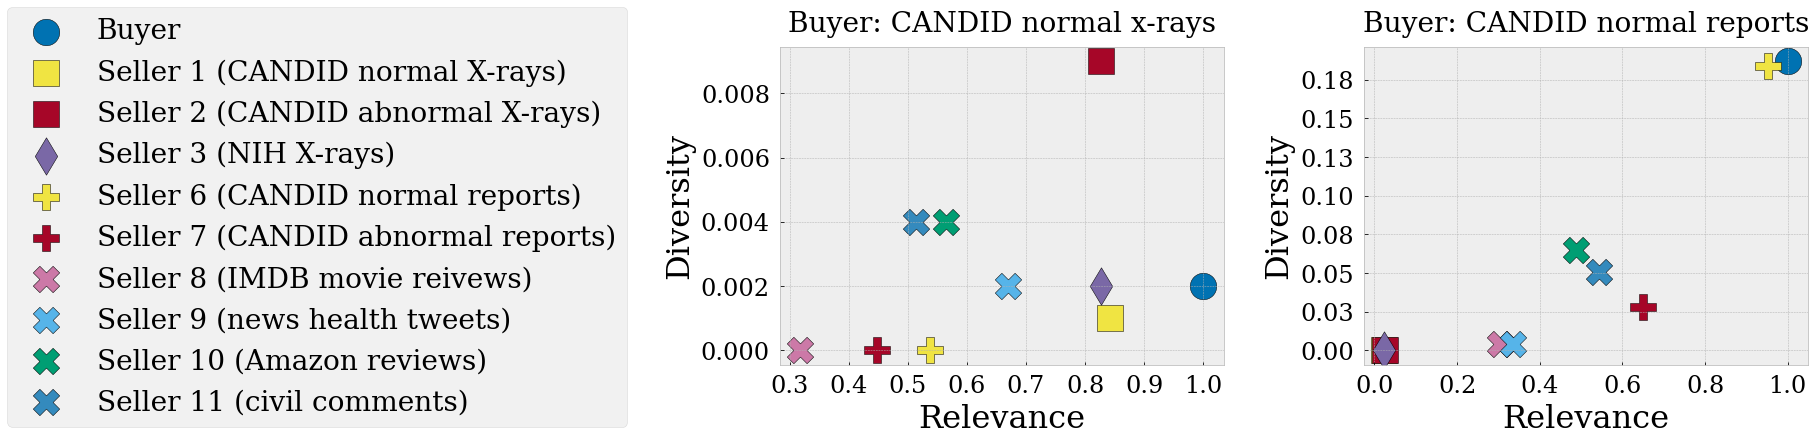

In [1120]:
fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(17, 7), ncols=2)
ax[0].scatter(buyer_image_buyer_candid_normal_image_rel, buyer_image_buyer_candid_normal_image_vol, c='#0072B2', marker='o', edgecolor='k', s=s, label=r'Buyer (CANDID normal x-ray images)')
ax[0].scatter(buyer_image_seller_candid_normal_image_rel, buyer_image_seller_candid_normal_image_vol, c='#F0E442', marker='s', edgecolor='k', s=s, label=r'Seller 1 (CANDID normal x-ray images)')
ax[0].scatter(buyer_image_seller_candid_abnormal_image_rel, buyer_image_seller_candid_abnormal_image_vol, c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (CANDID abnormal x-ray images)')
ax[0].scatter(buyer_image_seller_nih_rel, buyer_image_seller_nih_vol, c='C2', marker='d', edgecolor='k', s=s, label=r'Seller 3 (NIH x-ray images)')
# ax[0].scatter(buyer_image_seller_val_rel, buyer_image_seller_val_vol, c='C3',  marker='d', edgecolor='k', s=s, label=r'Seller 4 (ImageNet)')
# ax[0].scatter(buyer_image_seller_wild_rel, buyer_image_seller_wild_vol, c='C4',  marker='d', edgecolor='k', s=s, label=r'Seller 5 (iWildCam)')

ax[0].scatter(buyer_image_seller_candid_normal_report_rel, buyer_image_seller_candid_normal_report_vol, c='#F0E442', marker='P', edgecolor='k', s=s, label=r'Seller 6 (CANDID normal reports)')
ax[0].scatter(buyer_image_seller_candid_abnormal_report_rel, buyer_image_seller_candid_abnormal_report_vol, c='C1', marker='P', edgecolor='k', s=s, label=r'Seller 7 (CANDID abnormal reports)')
ax[0].scatter(buyer_image_seller_imdb_rel, buyer_image_seller_imdb_vol, c='C5', marker='X', edgecolor='k', s=s, label=r'Seller 8 (IMDB)')
ax[0].scatter(buyer_image_seller_tweets_rel, buyer_image_seller_tweets_vol, c='C6', marker='X', edgecolor='k', s=s, label=r'Seller 9 (Health tweets)')
ax[0].scatter(buyer_image_seller_amazon_id1_rel, buyer_image_seller_amazon_id1_vol, c='C7', marker='X', edgecolor='k', s=s, label=r'Seller 10 (Amazon)')
ax[0].scatter(buyer_image_seller_civil_rel, buyer_image_seller_civil_vol, c='C0', marker='X', edgecolor='k', s=s, label=r'Seller 9 (Civil)')
ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].scatter(buyer_text_buyer_candid_normal_report_rel, buyer_text_buyer_candid_normal_report_vol, c='#0072B2', marker='o', edgecolor='k', s=s, label=r'Buyer')
ax[1].scatter(buyer_text_seller_candid_normal_image_rel, buyer_text_seller_candid_normal_image_vol, c='#F0E442', marker='s', edgecolor='k', s=s, label=r'Seller 1 (CANDID normal X-rays)')
ax[1].scatter(buyer_text_seller_candid_abnormal_image_rel, buyer_text_seller_candid_abnormal_image_vol, c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (CANDID abnormal X-rays)')
ax[1].scatter(buyer_text_seller_nih_rel, buyer_text_seller_nih_vol, c='C2', marker='d', edgecolor='k', s=s, label=r'Seller 3 (NIH X-rays)')
# ax[1].scatter(buyer_text_seller_val_rel, buyer_text_seller_val_vol, c='C3',  marker='d', edgecolor='k', s=s, label=r'Seller 4 (ImageNet)')
# ax[1].scatter(buyer_text_seller_wild_rel, buyer_text_seller_wild_vol, c='C4',  marker='d', edgecolor='k', s=s, label=r'Seller 5 (iWildCam)')
ax[1].scatter(buyer_text_seller_candid_normal_report_rel, buyer_text_seller_candid_normal_report_vol, c='#F0E442', marker='P', edgecolor='k', s=s, label=r'Seller 6 (CANDID normal reports)')
ax[1].scatter(buyer_text_seller_candid_abnormal_report_rel, buyer_text_seller_candid_abnormal_report_vol, c='C1', marker='P', edgecolor='k', s=s, label=r'Seller 7 (CANDID abnormal reports)')
ax[1].scatter(buyer_text_seller_imdb_rel, buyer_text_seller_imdb_vol, c='C5', marker='X', edgecolor='k', s=s, label=r'Seller 8 (IMDB movie reivews)')
ax[1].scatter(buyer_text_seller_tweets_rel, buyer_text_seller_tweets_vol, c='C6', marker='X', edgecolor='k', s=s, label=r'Seller 9 (news health tweets)')
ax[1].scatter(buyer_text_seller_amazon_id1_rel, buyer_text_seller_amazon_id1_vol, c='C7', marker='X', edgecolor='k', s=s, label=r'Seller 10 (Amazon reviews)')
ax[1].scatter(buyer_text_seller_civil_rel, buyer_text_seller_civil_vol, c='C0', marker='X', edgecolor='k', s=s, label=r'Seller 11 (civil comments)')
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

# ax[0].set_xlim(0.00, 1.05)
# ax[1].set_xlim(0.00, 1.05)
# y_max = max(ax[0].get_yticks().max(), ax[1].get_yticks().max())
# ax[0].set_ylim(-0.05, y_max)
# ax[1].set_ylim(-0.05, y_max)

ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.3f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
# ax[0].set_yticks([0, 0.1, 0.3, 0.5, 0.7, 0.9], [0, 0.1, 0.3, 0.5, 0.7, 0.9], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
ax[0].set_title('Buyer: CANDID normal x-rays', fontsize=fontsize-4, pad=15)

ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([f'{y:.2f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
# ax[1].set_yticks([0, 0.1, 0.3, 0.5, 0.7, 0.9], [0, 0.1, 0.3, 0.5, 0.7, 0.9], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
ax[1].set_title('Buyer: CANDID normal reports', fontsize=fontsize-4, pad=15)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(-1.63, 1.17))
plt.savefig(figures / f'clip-multi-modal.pdf', bbox_inches='tight')
plt.show()

**distribution shift with WILDS dataset**

In [ ]:
wild_id1 = wild.get_subset('train')
wild_id2 = wild.get_subset('id_val')
wild_id3 = wild.get_subset('id_test')
wild_od1 = wild.get_subset('val')
wild_od2 = wild.get_subset('test')

fmow_id1 = fmow.get_subset('train')
fmow_id2 = fmow.get_subset('id_val')
fmow_id3 = fmow.get_subset('id_test')
fmow_od1 = fmow.get_subset('val')
fmow_od2 = fmow.get_subset('test')

amazon_id1 = amazon.get_subset('train')
amazon_id2 = amazon.get_subset('id_val')
amazon_id3 = amazon.get_subset('id_test')
amazon_od1 = amazon.get_subset('val')
amazon_od2 = amazon.get_subset('test')

In [1169]:
num_samples = 10000
batch_size = 32
wild_id1_loader = torch.utils.data.DataLoader(Simple_DS(Subset(wild_id1, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
wild_id2_loader = torch.utils.data.DataLoader(Simple_DS(Subset(wild_id2, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
wild_id3_loader = torch.utils.data.DataLoader(Simple_DS(Subset(wild_id3, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
wild_od1_loader = torch.utils.data.DataLoader(Simple_DS(Subset(wild_od1, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
wild_od2_loader = torch.utils.data.DataLoader(Simple_DS(Subset(wild_od2, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)

fmow_id1_loader = torch.utils.data.DataLoader(Simple_DS(Subset(fmow_id1, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
fmow_id2_loader = torch.utils.data.DataLoader(Simple_DS(Subset(fmow_id2, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
fmow_id3_loader = torch.utils.data.DataLoader(Simple_DS(Subset(fmow_id3, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
fmow_od1_loader = torch.utils.data.DataLoader(Simple_DS(Subset(fmow_od1, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)
fmow_od2_loader = torch.utils.data.DataLoader(Simple_DS(Subset(fmow_od2, np.arange(num_samples)), transforms=clip_preprocess), batch_size=batch_size)

amazon_id1_loader = torch.utils.data.DataLoader(Simple_DS(Subset(amazon_id1, np.arange(num_samples)), transforms=wild_text_transforms), batch_size=batch_size)
amazon_id2_loader = torch.utils.data.DataLoader(Simple_DS(Subset(amazon_id2, np.arange(num_samples)), transforms=wild_text_transforms), batch_size=batch_size)
amazon_id3_loader = torch.utils.data.DataLoader(Simple_DS(Subset(amazon_id3, np.arange(num_samples)), transforms=wild_text_transforms), batch_size=batch_size)
amazon_od1_loader = torch.utils.data.DataLoader(Simple_DS(Subset(amazon_od1, np.arange(num_samples)), transforms=wild_text_transforms), batch_size=batch_size)
amazon_od2_loader = torch.utils.data.DataLoader(Simple_DS(Subset(amazon_od2, np.arange(num_samples)), transforms=wild_text_transforms), batch_size=batch_size)

In [ ]:
amazon_id1_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(amazon_id1_loader))])
amazon_id2_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(amazon_id2_loader))])
amazon_id3_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(amazon_id3_loader))])
amazon_od1_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(amazon_od1_loader))])
amazon_od2_features = torch.cat([clip_model.encode_text(x.squeeze().cuda()).detach().cpu() for x in tqdm(iter(amazon_od2_loader))])

wild_id1_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(wild_id1_loader))])
wild_id2_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(wild_id2_loader))])
wild_id3_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(wild_id3_loader))])
wild_od1_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(wild_od1_loader))])
wild_od2_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(wild_od2_loader))])

fmow_id1_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(fmow_id1_loader))])
fmow_id2_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(fmow_id2_loader))])
fmow_id3_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(fmow_id3_loader))])
fmow_od1_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(fmow_od1_loader))])
fmow_od2_features = torch.cat([clip_model.encode_image(x.cuda()).detach().cpu() for x in tqdm(iter(fmow_od2_loader))])

 16%|██████████████▋                                                                               | 49/313 [00:45<04:07,  1.06it/s]

In [ ]:
n_components = 3
whiten       = True
omega = 0.2
threshold = 1e-1

amazon_pca, amazon_cov, amazon_values, amazon_components = utils.fit_buyer(amazon_id1_features, n_components=1)

amazon_amazon_id1_rel, amazon_amazon_id1_div, amazon_amazon_id1_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(amazon_id1_features, amazon_pca), omega=omega)
amazon_amazon_id2_rel, amazon_amazon_id2_div, amazon_amazon_id2_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(amazon_id2_features, amazon_pca), omega=omega)
amazon_amazon_id3_rel, amazon_amazon_id3_div, amazon_amazon_id3_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(amazon_id3_features, amazon_pca), omega=omega)
amazon_amazon_od1_rel, amazon_amazon_od1_div, amazon_amazon_od1_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(amazon_od1_features, amazon_pca), omega=omega)
amazon_amazon_od2_rel, amazon_amazon_od2_div, amazon_amazon_od2_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(amazon_od2_features, amazon_pca), omega=omega)

amazon_wild_id1_rel, amazon_wild_id1_div, amazon_wild_id1_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(wild_id1_features, amazon_pca), omega=omega)
amazon_wild_id2_rel, amazon_wild_id2_div, amazon_wild_id2_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(wild_id2_features, amazon_pca), omega=omega)
amazon_wild_id3_rel, amazon_wild_id3_div, amazon_wild_id3_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(wild_id3_features, amazon_pca), omega=omega)
amazon_wild_od1_rel, amazon_wild_od1_div, amazon_wild_od1_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(wild_od1_features, amazon_pca), omega=omega)
amazon_wild_od2_rel, amazon_wild_od2_div, amazon_wild_od2_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(wild_od2_features, amazon_pca), omega=omega)

amazon_fmow_id1_rel, amazon_fmow_id1_div, amazon_fmow_id1_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(fmow_id1_features, amazon_pca), omega=omega)
amazon_fmow_id2_rel, amazon_fmow_id2_div, amazon_fmow_id2_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(fmow_id2_features, amazon_pca), omega=omega)
amazon_fmow_id3_rel, amazon_fmow_id3_div, amazon_fmow_id3_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(fmow_id3_features, amazon_pca), omega=omega)
amazon_fmow_od1_rel, amazon_fmow_od1_div, amazon_fmow_od1_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(fmow_od1_features, amazon_pca), omega=omega)
amazon_fmow_od2_rel, amazon_fmow_od2_div, amazon_fmow_od2_vol = utils.get_valuation(amazon_values, amazon_components, *utils.project_seller(fmow_od2_features, amazon_pca), omega=omega)

wild_pca, wild_cov, wild_values, wild_components = utils.fit_buyer(wild_id1_features, n_components=n_components)

wild_amazon_id1_rel, wild_amazon_id1_div, wild_amazon_id1_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(amazon_id1_features, wild_pca), omega=omega)
wild_amazon_id2_rel, wild_amazon_id2_div, wild_amazon_id2_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(amazon_id2_features, wild_pca), omega=omega)
wild_amazon_id3_rel, wild_amazon_id3_div, wild_amazon_id3_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(amazon_id3_features, wild_pca), omega=omega)
wild_amazon_od1_rel, wild_amazon_od1_div, wild_amazon_od1_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(amazon_od1_features, wild_pca), omega=omega)
wild_amazon_od2_rel, wild_amazon_od2_div, wild_amazon_od2_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(amazon_od2_features, wild_pca), omega=omega)

wild_wild_id1_rel, wild_wild_id1_div, wild_wild_id1_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(wild_id1_features, wild_pca), omega=omega)
wild_wild_id2_rel, wild_wild_id2_div, wild_wild_id2_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(wild_id2_features, wild_pca), omega=omega)
wild_wild_id3_rel, wild_wild_id3_div, wild_wild_id3_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(wild_id3_features, wild_pca), omega=omega)
wild_wild_od1_rel, wild_wild_od1_div, wild_wild_od1_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(wild_od1_features, wild_pca), omega=omega)
wild_wild_od2_rel, wild_wild_od2_div, wild_wild_od2_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(wild_od2_features, wild_pca), omega=omega)

wild_fmow_id1_rel, wild_fmow_id1_div, wild_fmow_id1_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(fmow_id1_features, wild_pca), omega=omega)
wild_fmow_id2_rel, wild_fmow_id2_div, wild_fmow_id2_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(fmow_id2_features, wild_pca), omega=omega)
wild_fmow_id3_rel, wild_fmow_id3_div, wild_fmow_id3_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(fmow_id3_features, wild_pca), omega=omega)
wild_fmow_od1_rel, wild_fmow_od1_div, wild_fmow_od1_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(fmow_od1_features, wild_pca), omega=omega)
wild_fmow_od2_rel, wild_fmow_od2_div, wild_fmow_od2_vol = utils.get_valuation(wild_values, wild_components, *utils.project_seller(fmow_od2_features, wild_pca), omega=omega)

fmow_pca, fmow_cov, fmow_values, fmow_components = utils.fit_buyer(fmow_id1_features, n_components=n_components)

fmow_amazon_id1_rel, fmow_amazon_id1_div, fmow_amazon_id1_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(amazon_id1_features, fmow_pca), omega=omega)
fmow_amazon_id2_rel, fmow_amazon_id2_div, fmow_amazon_id2_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(amazon_id2_features, fmow_pca), omega=omega)
fmow_amazon_id3_rel, fmow_amazon_id3_div, fmow_amazon_id3_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(amazon_id3_features, fmow_pca), omega=omega)
fmow_amazon_od1_rel, fmow_amazon_od1_div, fmow_amazon_od1_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(amazon_od1_features, fmow_pca), omega=omega)
fmow_amazon_od2_rel, fmow_amazon_od2_div, fmow_amazon_od2_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(amazon_od2_features, fmow_pca), omega=omega)

fmow_wild_id1_rel, fmow_wild_id1_div, fmow_wild_id1_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(wild_id1_features, fmow_pca), omega=omega)
fmow_wild_id2_rel, fmow_wild_id2_div, fmow_wild_id2_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(wild_id2_features, fmow_pca), omega=omega)
fmow_wild_id3_rel, fmow_wild_id3_div, fmow_wild_id3_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(wild_id3_features, fmow_pca), omega=omega)
fmow_wild_od1_rel, fmow_wild_od1_div, fmow_wild_od1_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(wild_od1_features, fmow_pca), omega=omega)
fmow_wild_od2_rel, fmow_wild_od2_div, fmow_wild_od2_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(wild_od2_features, fmow_pca), omega=omega)

fmow_fmow_id1_rel, fmow_fmow_id1_div, fmow_fmow_id1_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(fmow_id1_features, fmow_pca), omega=omega)
fmow_fmow_id2_rel, fmow_fmow_id2_div, fmow_fmow_id2_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(fmow_id2_features, fmow_pca), omega=omega)
fmow_fmow_id3_rel, fmow_fmow_id3_div, fmow_fmow_id3_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(fmow_id3_features, fmow_pca), omega=omega)
fmow_fmow_od1_rel, fmow_fmow_od1_div, fmow_fmow_od1_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(fmow_od1_features, fmow_pca), omega=omega)
fmow_fmow_od2_rel, fmow_fmow_od2_div, fmow_fmow_od2_vol = utils.get_valuation(fmow_values, fmow_components, *utils.project_seller(fmow_od2_features, fmow_pca), omega=omega)

/tmp/ipykernel_1868/2044923912.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.2f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2044923912.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.2f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2044923912.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.2f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1868/2044923912.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{y:.2f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)


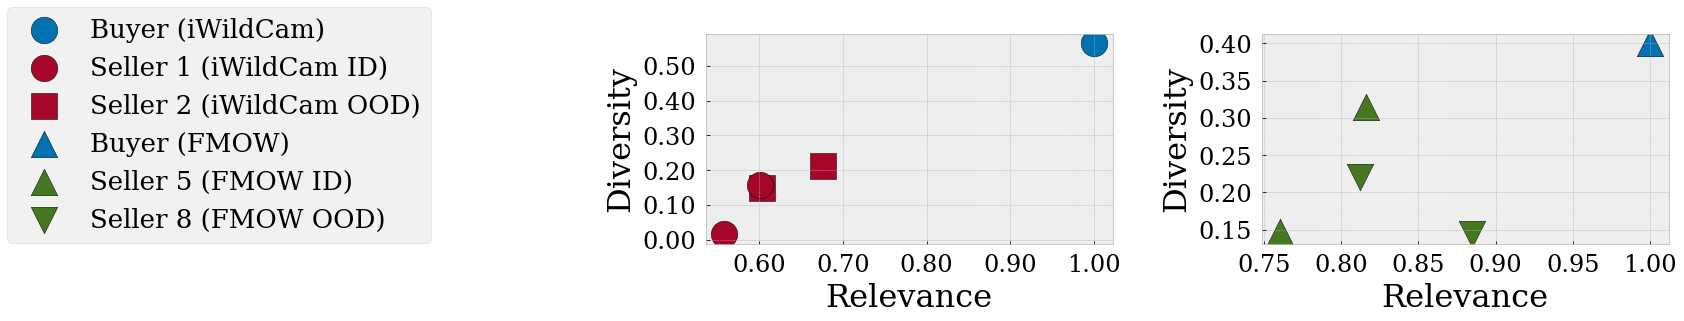

In [1173]:

fontsize = 32
s = 700

fig, ax = plt.subplots(figsize=(16, 5), ncols=2)

ax[0].scatter(wild_wild_id1_rel, wild_wild_id1_vol, c='#0072B2', marker='o', edgecolor='k', s=s, label=r'Buyer (iWildCam)')
ax[0].scatter(wild_wild_od1_rel, wild_wild_od1_vol, c='C1', marker='o', edgecolor='k', s=s, label=r'Seller 1 (iWildCam ID)')
ax[0].scatter(wild_wild_id2_rel, wild_wild_id2_vol, c='C1', marker='s', edgecolor='k', s=s, label=r'Seller 2 (iWildCam OOD)')
ax[0].scatter(wild_wild_id3_rel, wild_wild_id3_vol, c='C1', marker='s', edgecolor='k', s=s)
ax[0].scatter(wild_wild_od2_rel, wild_wild_od2_vol, c='C1', marker='o', edgecolor='k', s=s)

ax[1].scatter(amazon_amazon_id1_rel, amazon_amazon_id1_vol, c='#0072B2', marker='P', edgecolor='k', s=s, label=r'Buyer (Amazon)')
ax[1].scatter(amazon_amazon_id2_rel, amazon_amazon_id2_vol, c='C2', marker='P', edgecolor='k', s=s, label=r'Seller 1 (Amazon ID)')
ax[1].scatter(amazon_amazon_id3_rel, amazon_amazon_id3_vol, c='C2', marker='P', edgecolor='k', s=s)
ax[1].scatter(amazon_amazon_od1_rel, amazon_amazon_od1_vol, c='C2', marker='X', edgecolor='k', s=s, label=r'Seller 2 (Amazon OOD)')
ax[1].scatter(amazon_amazon_od2_rel, amazon_amazon_od2_vol, c='C2', marker='X', edgecolor='k', s=s)

ax[2].scatter(fmow_fmow_id1_rel, fmow_fmow_id1_vol, c='#0072B2', marker='^', edgecolor='k', s=s, label=r'Buyer (FMOW)')
ax[2].scatter(fmow_fmow_id2_rel, fmow_fmow_id2_vol, c='C3', marker='^', edgecolor='k', s=s, label=r'Seller 5 (FMOW ID)')
ax[2].scatter(fmow_fmow_id3_rel, fmow_fmow_id3_vol, c='C3', marker='^', edgecolor='k', s=s, )
ax[2].scatter(fmow_fmow_od1_rel, fmow_fmow_od1_vol, c='C3', marker='v', edgecolor='k', s=s, label=r'Seller 8 (FMOW OOD)')
ax[2].scatter(fmow_fmow_od2_rel, fmow_fmow_od2_vol, c='C3', marker='v', edgecolor='k', s=s, )

ax[0].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[0].set_ylabel('Diversity', fontsize=32, labelpad=6)

ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Diversity', fontsize=32, labelpad=6)

# ax[0].set_xlim(0.50, 1.05)
# ax[1].set_xlim(0.95, 1.05)
# ax[0].set_ylim(0.00, 0.25)
# ax[1].set_ylim(0.60, 0.70)
# y_max = max(ax[0].get_yticks().max(), ax[1].get_yticks().max())
# ax[0].set_ylim(-0.05, y_max)
# ax[1].set_ylim(-0.05, y_max)

ax[0].set_xticklabels([f'{x:.2f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.2f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
# ax[0].set_yticks([0, 0.1, 0.3, 0.5, 0.7, 0.9], [0, 0.1, 0.3, 0.5, 0.7, 0.9], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)
# ax[0].set_title('Buyer: iWildCam images', fontsize=fontsize-4, pad=15)

ax[1].set_xticklabels([f'{x:.2f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([f'{y:.2f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
# ax[1].set_yticks([0, 0.1, 0.3, 0.5, 0.7, 0.9], [0, 0.1, 0.3, 0.5, 0.7, 0.9], fontsize=fontsize-8)
ax[1].tick_params(axis='both', which='major', pad=10)
# ax[1].set_title('Buyer: Amazon reviews', fontsize=fontsize-4, pad=15)

# ax[1].set_xticklabels([f'{x:.2f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
# ax[1].set_yticklabels([f'{y:.2f}' for y in ax[1].get_yticks()], fontsize=fontsize-8)
# # ax[1].set_yticks([0, 0.1, 0.3, 0.5, 0.7, 0.9], [0, 0.1, 0.3, 0.5, 0.7, 0.9], fontsize=fontsize-8)
# ax[1].tick_params(axis='both', which='major', pad=10)
# # ax[1].set_title('Buyer: FMOW', fontsize=fontsize-4, pad=15)

plt.tight_layout(pad=4)
# plt.legend()
handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels())]
fig.legend(handles, labels, loc='upper center', prop={'size': fontsize-6}, bbox_to_anchor=(-0.30, 1.00))
plt.savefig(figures / f'wild-domain-shift.pdf', bbox_inches='tight')
plt.show()